In [1]:
import pandas as pd
import numpy as np
import openpyxl
import keras 
import time
import tensorflow
import math
import pickle

from keras.models import Sequential 
from keras.layers import Dense 
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from sklearn import preprocessing 
from sklearn.preprocessing import scale

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.backend.experimental import enable_tf_random_generator
set_random_seed(2022)
from matplotlib import pyplot as plt
%matplotlib inline

#parametry
from keras.utils.layer_utils import count_params
#scheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay, PolynomialDecay, InverseTimeDecay
#cross valid
from sklearn.model_selection import KFold
#customowe metryki
from keras import backend as K

In [2]:
print(tensorflow.__version__)

2.8.2


## Tytul pracy
## Jakub Bandurski
 tekst rozwiazanie

> Blok z wcięciem



In [ ]:
#dodatkowe metryki
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def R2oos(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
#Dane
df = pd.read_excel ('/content/drive/My Drive/Colab Notebooks2/danev2.xlsx',engine='openpyxl')
df.drop('Unnamed: 0',axis=1,inplace=True)

df = df.iloc[1:df.shape[0]].reset_index(drop=True)
print(df.shape)
print(df.head())
target = df.columns[0]
features = list(df.columns)
del features[0]

df1 = df.copy(deep=True)
for col in features:
  df1[col+'2'] = df1[col]**2

for col in features:
  df1[col+'0'] = np.where(df1['SMALL LoBM']<0,0,df1[col])

features1 = list(df1.columns)
del features1[0]

df2 = df.copy(deep=True)

for col in features:
  df2[col+'0'] = np.where(df2['SMALL LoBM']<0,0,df2[col])

features2 = list(df2.columns)
del features2[0]

(9046, 15)
   SMALL LoBM  Mkt-RF   SMB   HML   RMW   CMA   Mom        MP        YP  \
0       -0.03    0.56 -0.08  0.21 -0.14  0.30  0.01  0.005086  0.020959   
1        1.02   -0.04  0.04  0.10 -0.22 -0.04  0.00  0.005086  0.020959   
2       -1.05    1.38 -0.48  0.06 -0.29 -0.02 -0.03  0.005086  0.020959   
3       -1.81   -2.16  1.42  0.32 -0.09  0.14  0.15  0.005086  0.020959   
4        0.40   -1.17 -0.79 -0.13  0.04 -0.20 -0.53  0.005086  0.020959   

   ExpInf  DEI        UI       RHO   URP    UTS  
0     2.9 -0.6  0.986256 -3.861256  2.05  9.275  
1     2.9 -0.6  0.986256 -3.861256  2.05  9.285  
2     2.9 -0.6  0.986256 -3.861256  2.11  9.155  
3     2.9 -0.6  0.986256 -3.861256  1.98  9.335  
4     2.9 -0.6  0.986256 -3.861256  1.98  9.425  


In [ ]:
#wczytywanie modeli
GD_NN1 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GD_NN1', 
                                 custom_objects={'R2': R2, 'R2oos': R2oos})
GD_NN1.predict(df[features])

history_GD_NN1 = pickle.load(open('/content/drive/My Drive/Colab Notebooks/history/historyNN1GD', "rb"))
metrics = ['mse','RootMeanSquaredError',
           'mae','msle','logcosh','R2','R2oos']
for metric in metrics:
    if metric == 'RootMeanSquaredError': metric='root_mean_squared_error'
    plt.plot(history_GD_NN1[metric])
    plt.plot(history_GD_NN1['val_'+metric])
    plt.title(metric+ ' loss')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='center left')
    plt.show()

In [ ]:
#Definicja modelu
def NN(layers, inputShape, outputShape):
  model = Sequential()
  model.add(Dense(layers[0],input_shape=(inputShape,), kernel_initializer = 'normal', activation = 'relu'))
  for i in range(1, len(layers)):
    model.add(Dense(layers[i], kernel_initializer = 'normal', activation = 'relu'))
  
  model.add(Dense(outputShape, kernel_initializer = 'normal'))
  return model

In [ ]:
# Wrapper treningowy
def cross_validation(model, name, data, target, features, type_of_GD, epochs, n_splits):
  tensorflow.keras.backend.experimental.enable_tf_random_generator()
  set_random_seed(2022)

  metrics = ['mse','RootMeanSquaredError',
            'mae','msle','logcosh',R2,R2oos]
  #Cross val
  kf = KFold(n_splits=n_splits, shuffle=True,random_state=2022)

  # Zapamiętujemy wyniki zbioru treningowego i testowego
  testResults = []
  hists=[]
  start = time.time()
  #glowna petla
  for train_index, test_index in kf.split(data):
    start1 = time.time()
    #folds
    train, test = data.iloc[train_index], data.iloc[test_index]
    #Preprocessing
    x_train = preprocessing.scale(train[features]) 
    scaler = preprocessing.StandardScaler().fit(train[features]) 
    x_test = scaler.transform(test[features])
    y_train = train[target]
    y_test = test[target]

    model.compile(
        loss = 'mse', 
        optimizer = SGD(learning_rate=ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=-1000,
        decay_rate=math.exp(1)),
        global_clipnorm = 1), 
        metrics = metrics,
    )
    if type_of_GD == 'GD':
      history = model.fit(
          x_train, y_train,    
          batch_size=len(x_train), 
          epochs = epochs, 
          verbose = 0,
          validation_split = 0,
          validation_data=(x_test, y_test),
          shuffle  = True
      )
    elif type_of_GD == 'SGD':
      history = model.fit(
        x_train, y_train,    
        batch_size=1, 
        epochs = epochs,
        steps_per_epoch=1,
        validation_steps=1,
        verbose = 0,
        validation_split = 0,
        validation_data=(x_test, y_test),
        shuffle  = True
    )
    testResults.append(model.evaluate(x_test, y_test, verbose = 0) )
    hists.append(history)
    end1=time.time()
    print(f'czas petli: ', end1-start1)

  end = time.time()
  print("Czas działania pętli uczenia:", end-start)
  model.save(filepath='/content/drive/My Drive/Colab Notebooks2/'+name)
  with open('/content/drive/My Drive/Colab Notebooks2/history/history'+name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
  testResults = np.asarray(testResults)
  print('Test loss:', np.mean(testResults[:,0])) 
  print('Test mse:', np.mean(testResults[:,1]))
  print('Test rmse:', np.mean(testResults[:,2]))
  print('Test mae:', np.mean(testResults[:,3]))
  print('Test msle:', np.mean(testResults[:,4]))
  print('Test logcosh:', np.mean(testResults[:,5]))
  print('Test R^2:', np.mean(testResults[:,6]))
  print('Test R^2oos:', np.mean(testResults[:,7]))

  #plots
  metrics = ['mse','RootMeanSquaredError',
            'mae','msle','logcosh','R2','R2oos']
  for metric in metrics:
    if metric == 'RootMeanSquaredError': metric='root_mean_squared_error'
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title(metric+ ' loss')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='center left')
    plt.show()
  return testResults

In [ ]:
GD_NN1df1 = NN([32],42,1)
SGD_NN1df1 = NN([32],42,1)
GD_NN2df1 = NN([32,16],42,1)
SGD_NN2df1 = NN([32,16],42,1)
GD_NN3df1 = NN([32,16,8],42,1)
SGD_NN3df1 = NN([32,16,8],42,1)
GD_NN4df1 = NN([32,16,8,4],42,1)
SGD_NN4df1 = NN([32,16,8,4],42,1)
GD_NN5df1 = NN([32,16,8,4,2],42,1)
SGD_NN5df1 = NN([32,16,8,4,2],42,1)
GD_NN1df = NN([32],14,1)
SGD_NN1df = NN([32],14,1)
GD_NN2df = NN([32,16],14,1)
SGD_NN2df = NN([32,16],14,1)
GD_NN3df = NN([32,16,8],14,1)
SGD_NN3df = NN([32,16,8],14,1)
GD_NN4df = NN([32,16,8,4],14,1)
SGD_NN4df = NN([32,16,8,4],14,1)
GD_NN5df = NN([32,16,8,4,2],14,1)
SGD_NN5df = NN([32,16,8,4,2],14,1)
GD_NN1df2 = NN([32],28,1)
SGD_NN1df2 = NN([32],28,1)
GD_NN2df2 = NN([32,16],28,1)
SGD_NN2df2 = NN([32,16],28,1)
GD_NN3df2 = NN([32,16,8],28,1)
SGD_NN3df2 = NN([32,16,8],28,1)
GD_NN4df2 = NN([32,16,8,4],28,1)
SGD_NN4df2 = NN([32,16,8,4],28,1)
GD_NN5df2 = NN([32,16,8,4,2],28,1)
SGD_NN5df2 = NN([32,16,8,4,2],28,1)

NN1 GD 42 cechy:
czas petli:  34.027827739715576
czas petli:  29.709377765655518
czas petli:  30.338186502456665
czas petli:  41.563679933547974
czas petli:  30.88911199569702
czas petli:  31.361979722976685
czas petli:  33.037938594818115
czas petli:  32.266990661621094
czas petli:  31.51485824584961
czas petli:  31.971877813339233
Czas działania pętli uczenia: 326.70068287849426
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN1df1/assets
Test loss: 0.6832185924053192
Test mse: 0.6832185924053192
Test rmse: 0.8233686983585358
Test mae: 0.5845329880714416
Test msle: 0.06127324625849724
Test logcosh: 0.23895945399999619
Test R^2: 0.5857253670692444
Test R^2oos: 0.6035448610782623


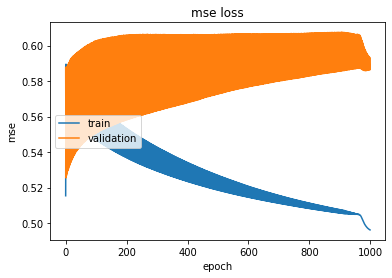

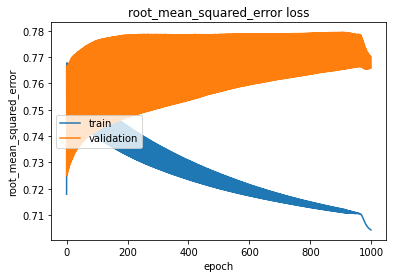

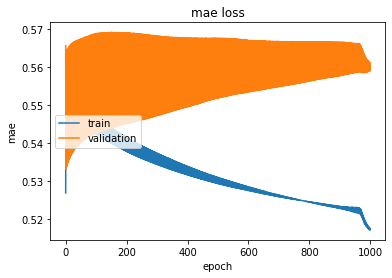

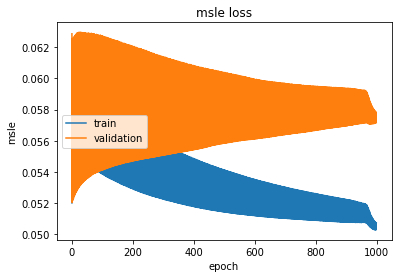

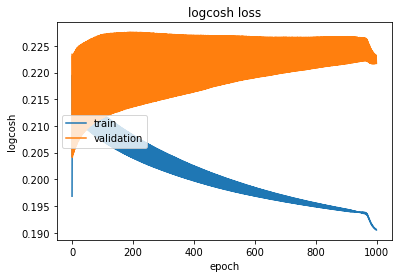

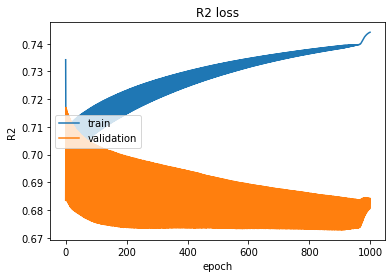

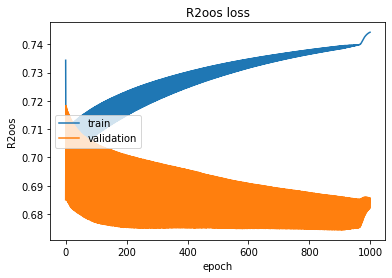

NN1 SGD 42 cechy:
czas petli:  29.587015390396118
czas petli:  29.452773809432983
czas petli:  28.842449426651
czas petli:  27.983818769454956
czas petli:  29.059033393859863
czas petli:  28.59066343307495
czas petli:  29.022358179092407
czas petli:  29.346668243408203
czas petli:  29.052091360092163
czas petli:  41.816832304000854
Czas działania pętli uczenia: 302.77152132987976
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN1df1/assets
Test loss: 0.9903557419776916
Test mse: 0.9903557419776916
Test rmse: 0.9898034155368804
Test mae: 0.643674510717392
Test msle: 0.07098801992833614
Test logcosh: 0.29553971588611605
Test R^2: 0.4692614287137985
Test R^2oos: 0.49219214618206025


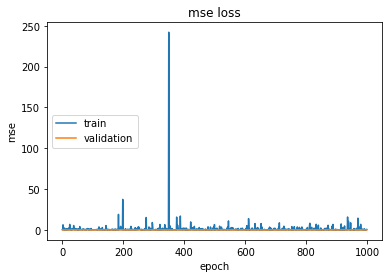

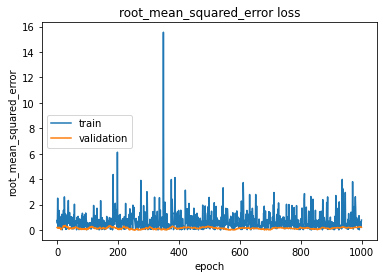

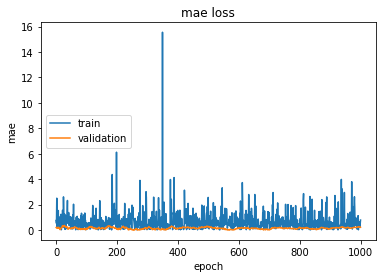

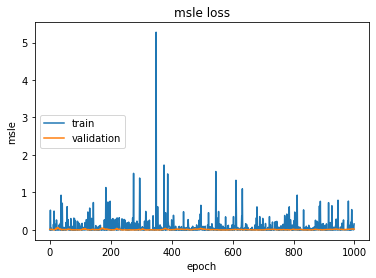

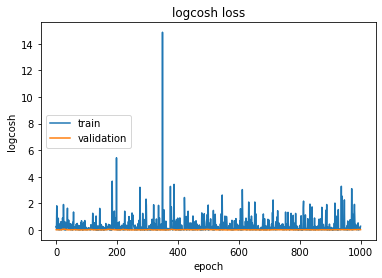

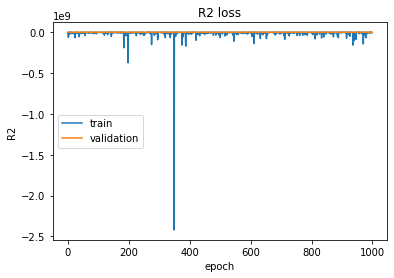

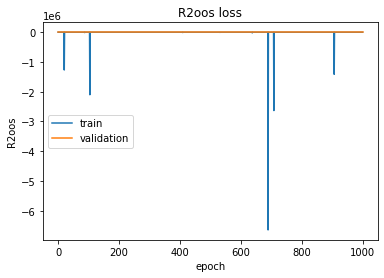

NN2 GD 42 cechy:
czas petli:  33.551685094833374
czas petli:  32.770082235336304
czas petli:  32.298139333724976
czas petli:  32.61147665977478
czas petli:  33.34123086929321
czas petli:  33.13185715675354
czas petli:  33.91892194747925
czas petli:  33.73733568191528
czas petli:  33.254236459732056
czas petli:  32.89959788322449
Czas działania pętli uczenia: 331.5326406955719
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN2df1/assets
Test loss: 0.7037334203720093
Test mse: 0.7037334203720093
Test rmse: 0.8331160604953766
Test mae: 0.5833126127719879
Test msle: 0.0593071810901165
Test logcosh: 0.239907668530941
Test R^2: 0.5785145372152328
Test R^2oos: 0.5958724021911621


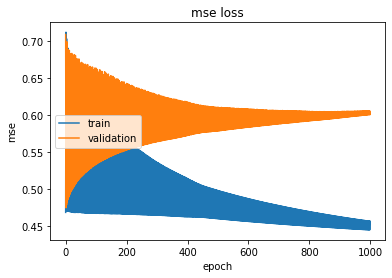

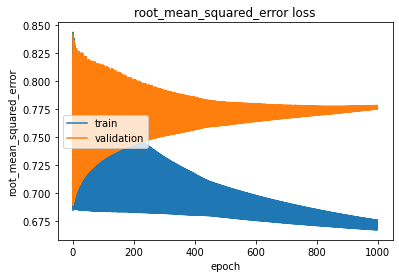

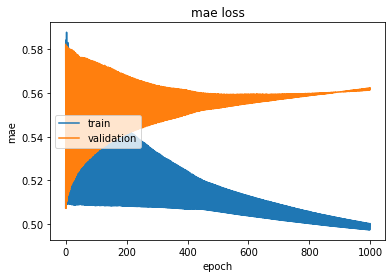

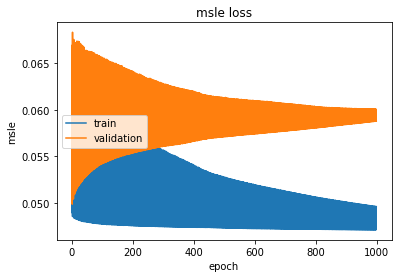

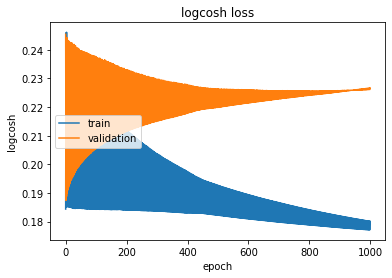

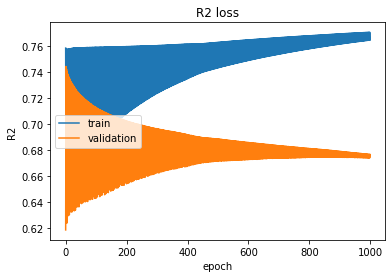

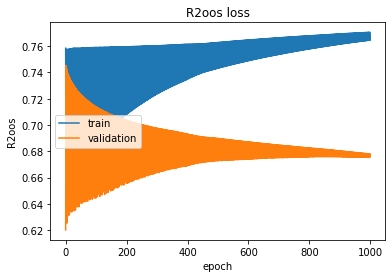

NN2 SGD 42 cechy:
czas petli:  30.248889684677124
czas petli:  29.757853031158447
czas petli:  29.47225522994995
czas petli:  29.39408230781555
czas petli:  29.502538204193115
czas petli:  41.79131507873535
czas petli:  29.260528087615967
czas petli:  28.966678857803345
czas petli:  28.66745615005493
czas petli:  29.081897020339966
Czas działania pętli uczenia: 306.1635103225708
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN2df1/assets
Test loss: 1.0168153822422028
Test mse: 1.0168153822422028
Test rmse: 1.0025049984455108
Test mae: 0.6423640608787536
Test msle: 0.07090226784348488
Test logcosh: 0.29600306153297423
Test R^2: 0.45799392759799956
Test R^2oos: 0.4813807219266891


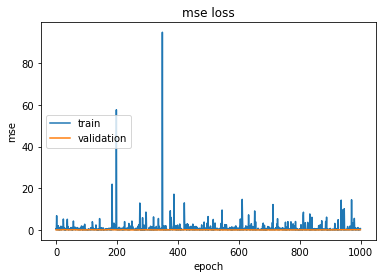

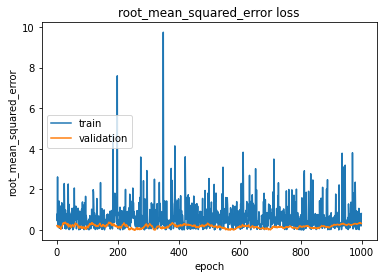

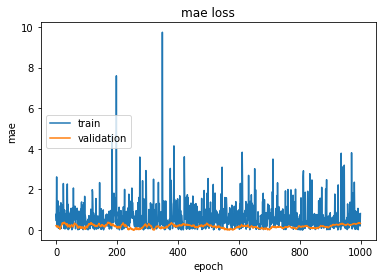

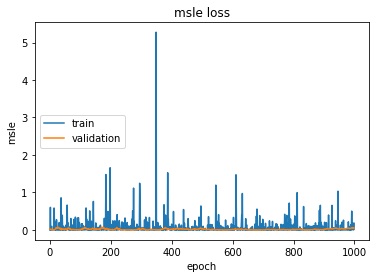

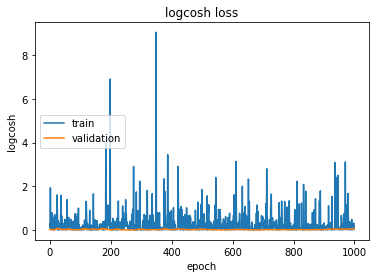

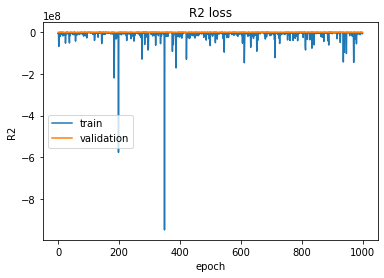

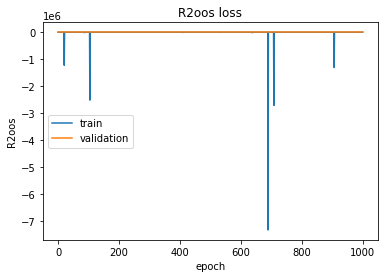

NN3 GD 42 cechy:
czas petli:  32.77304673194885
czas petli:  33.05706453323364
czas petli:  32.47792291641235
czas petli:  31.950858116149902
czas petli:  32.272451639175415
czas petli:  32.46294927597046
czas petli:  31.35604453086853
czas petli:  31.445398092269897
czas petli:  31.995298624038696
czas petli:  31.6005916595459
Czas działania pętli uczenia: 321.4086608886719
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN3df1/assets
Test loss: 0.7084974944591522
Test mse: 0.7084974944591522
Test rmse: 0.8355649411678314
Test mae: 0.5835058748722076
Test msle: 0.06081919670104981
Test logcosh: 0.24067481011152267
Test R^2: 0.5792862415313721
Test R^2oos: 0.597003948688507


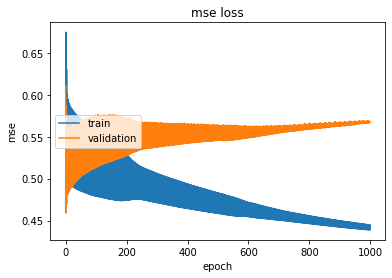

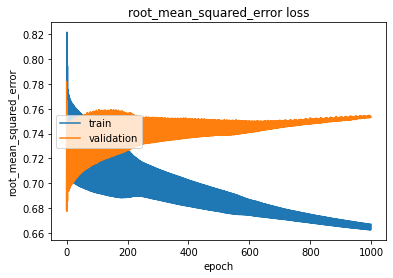

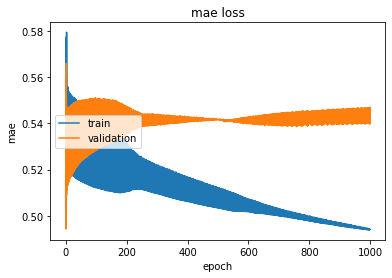

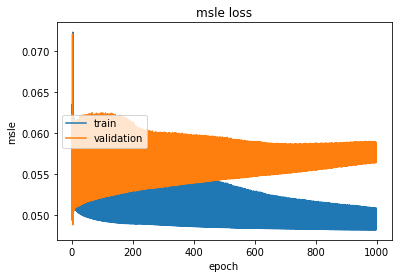

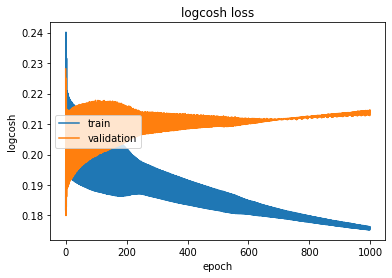

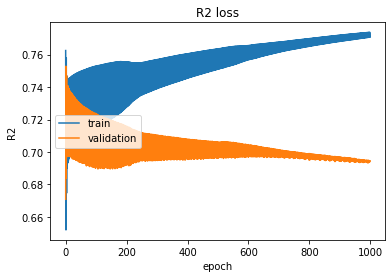

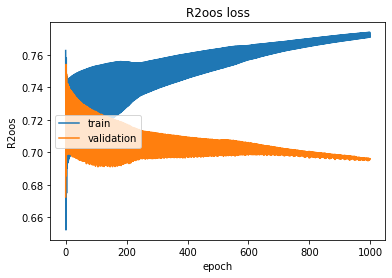

NN3 SGD 42 cechy:
czas petli:  29.536885976791382
czas petli:  29.160110235214233
czas petli:  28.999338626861572
czas petli:  41.87828969955444
czas petli:  30.55980920791626
czas petli:  29.713085651397705
czas petli:  29.156254529953003
czas petli:  29.326675415039062
czas petli:  28.851657390594482
czas petli:  29.09675621986389
Czas działania pętli uczenia: 306.2960042953491
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN3df1/assets
Test loss: 1.0264853298664094
Test mse: 1.0264853298664094
Test rmse: 1.007056587934494
Test mae: 0.6468994319438934
Test msle: 0.07579098269343376
Test logcosh: 0.2995247557759285
Test R^2: 0.4539858788251877
Test R^2oos: 0.4785338521003723


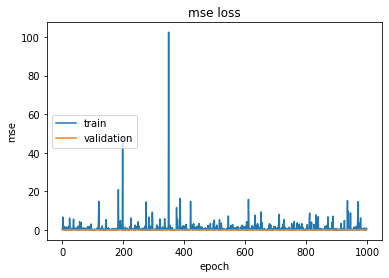

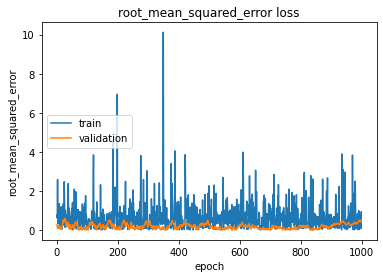

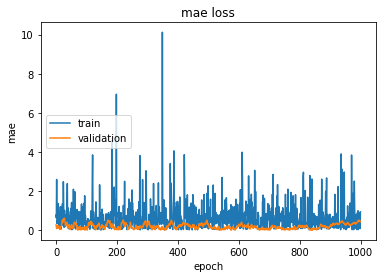

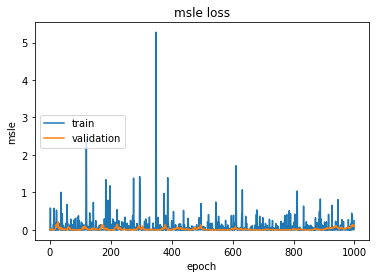

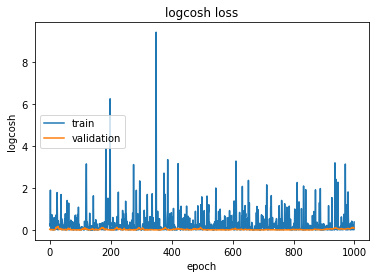

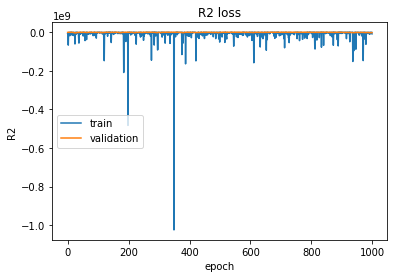

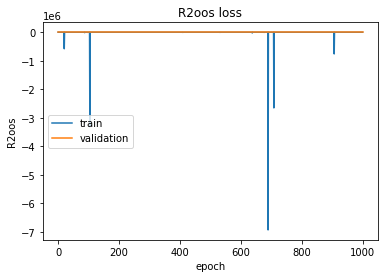

NN4 GD 42 cechy:
czas petli:  32.5513219833374
czas petli:  32.63363242149353
czas petli:  33.10921907424927
czas petli:  32.231414794921875
czas petli:  31.85557532310486
czas petli:  41.7293860912323
czas petli:  32.03499150276184
czas petli:  31.796730756759644
czas petli:  32.94999432563782
czas petli:  32.02824282646179
Czas działania pętli uczenia: 332.9376792907715
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN4df1/assets
Test loss: 0.8745728492736816
Test mse: 0.8745728492736816
Test rmse: 0.9139764487743378
Test mae: 0.632971054315567
Test msle: 0.08224778957664966
Test logcosh: 0.2786854445934296
Test R^2: 0.5106528513133526
Test R^2oos: 0.5320884957443923


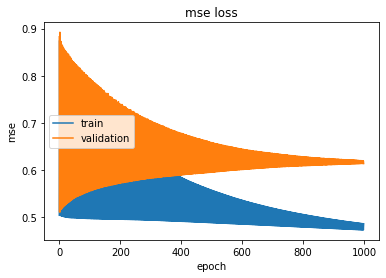

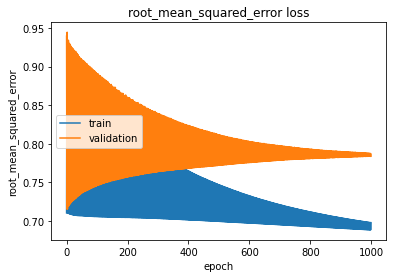

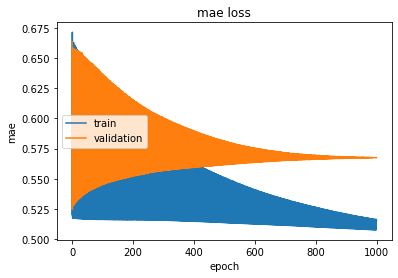

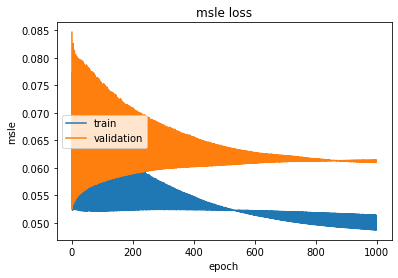

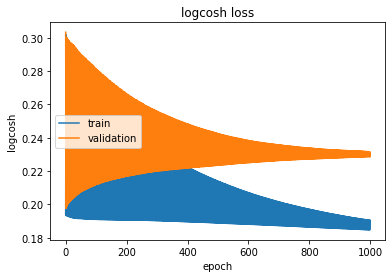

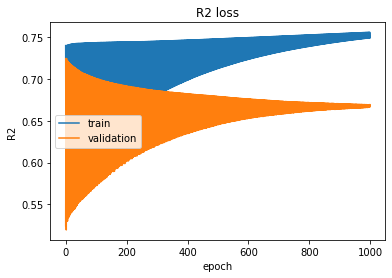

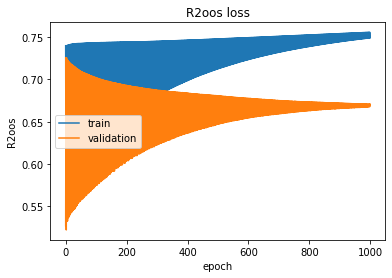

NN4 SGD 42 cechy:
czas petli:  41.88263559341431
czas petli:  41.88917136192322
czas petli:  29.408702850341797
czas petli:  28.901262760162354
czas petli:  30.09218716621399
czas petli:  29.414466619491577
czas petli:  28.840991258621216
czas petli:  28.820568561553955
czas petli:  29.24690556526184
czas petli:  28.675814867019653
Czas działania pętli uczenia: 317.1912877559662
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN4df1/assets
Test loss: 1.7735339403152466
Test mse: 1.7735339403152466
Test rmse: 1.3223762273788453
Test mae: 0.8973513662815094
Test msle: 0.17957040667533875
Test logcosh: 0.48916472792625426
Test R^2: 0.04309126529842615
Test R^2oos: 0.08257152681781008


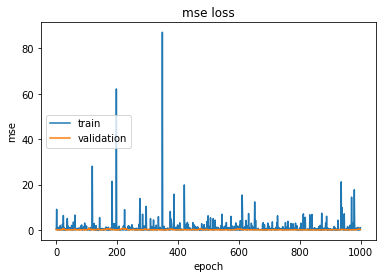

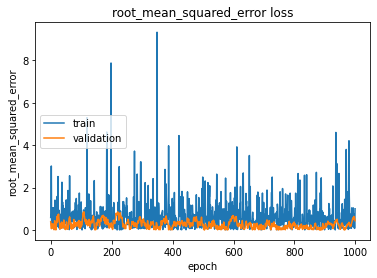

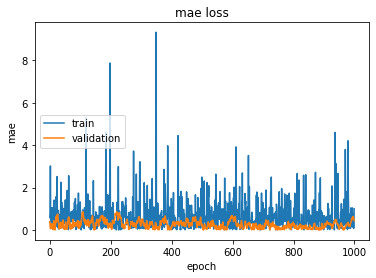

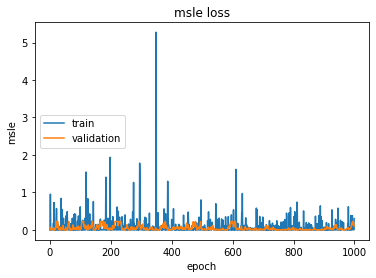

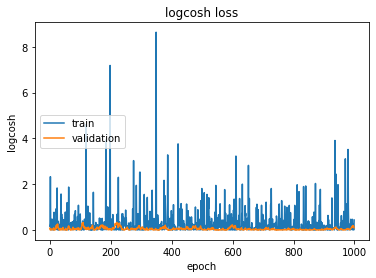

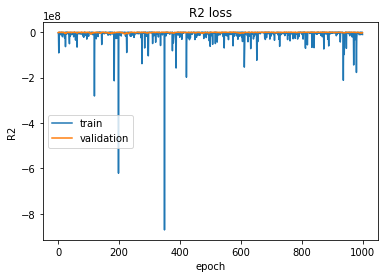

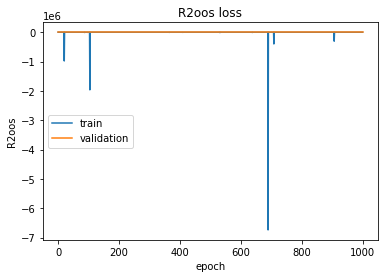

NN5 GD 42 cechy:
czas petli:  32.93143582344055
czas petli:  32.822359800338745
czas petli:  32.646724224090576
czas petli:  33.333231925964355
czas petli:  33.23417639732361
czas petli:  33.722878217697144
czas petli:  32.89816164970398
czas petli:  32.61752915382385
czas petli:  32.472076416015625
czas petli:  32.84818625450134
Czas działania pętli uczenia: 329.54634976387024
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN5df1/assets
Test loss: 1.9316911578178406
Test mse: 1.9316911578178406
Test rmse: 1.388060975074768
Test mae: 0.9562298595905304
Test msle: 0.23302721232175827
Test logcosh: 0.5318703800439835
Test R^2: -0.04187835734337568
Test R^2oos: 0.002476375678088516


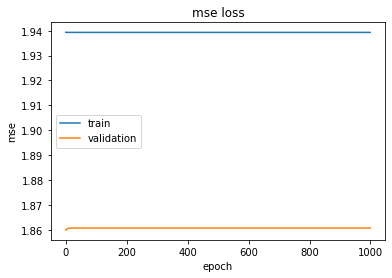

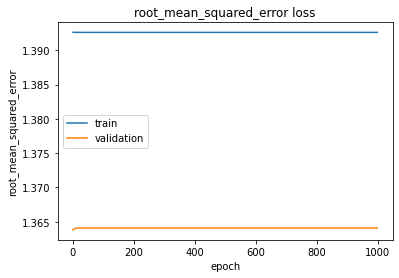

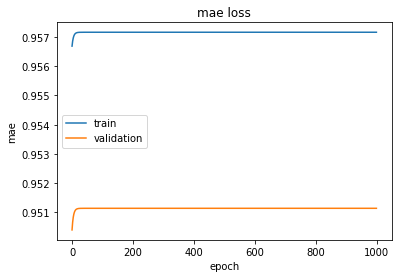

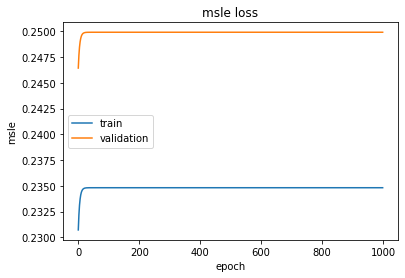

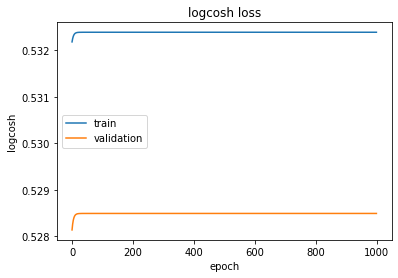

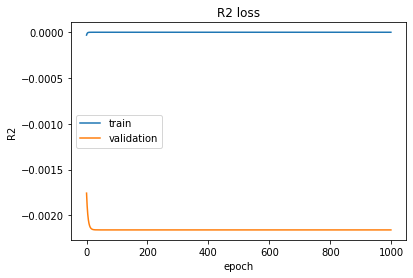

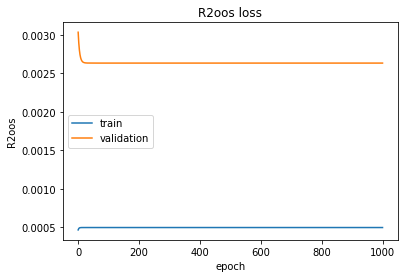

NN5 SGD 42 cechy:
czas petli:  29.53771424293518
czas petli:  29.587844371795654
czas petli:  29.36294722557068
czas petli:  29.25334405899048
czas petli:  41.8796546459198
czas petli:  29.489349603652954
czas petli:  29.42958354949951
czas petli:  41.99507117271423
czas petli:  29.37642502784729
czas petli:  29.561278581619263
Czas działania pętli uczenia: 319.48999762535095
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN5df1/assets
Test loss: 1.943259048461914
Test mse: 1.943259048461914
Test rmse: 1.3921756267547607
Test mae: 0.9564281821250915
Test msle: 0.20644546747207643
Test logcosh: 0.5332418978214264
Test R^2: -0.05214566607028246
Test R^2oos: -0.00778502481225587


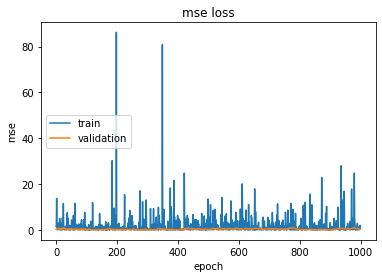

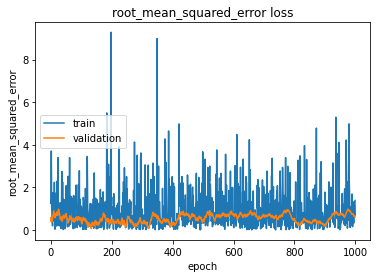

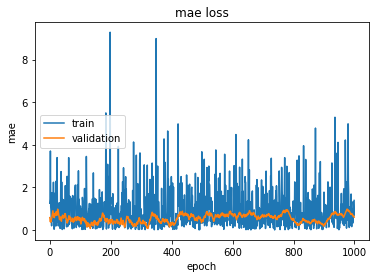

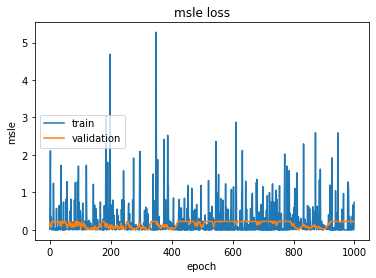

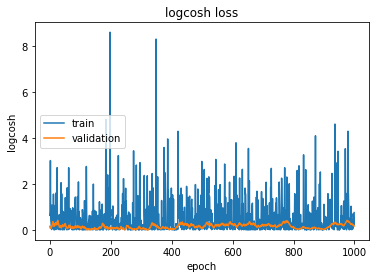

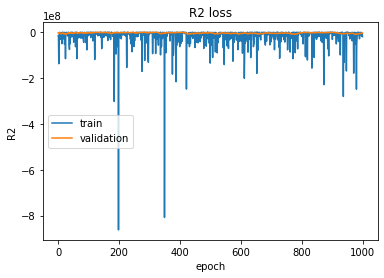

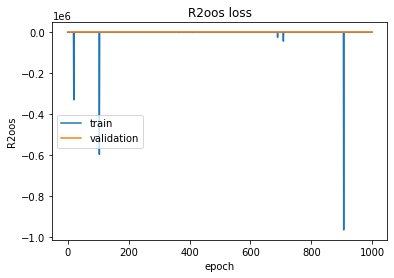

array([[ 2.09697843e+00,  2.09697843e+00,  1.44809473e+00,
         9.89875257e-01,  2.31807202e-01,  5.57643771e-01,
        -4.77168001e-02,  1.02098109e-02],
       [ 2.39945722e+00,  2.39945722e+00,  1.54901814e+00,
         1.00446391e+00,  2.03855783e-01,  5.75201631e-01,
        -4.39589135e-02,  4.94256290e-03],
       [ 2.02068758e+00,  2.02068758e+00,  1.42150891e+00,
         9.53991473e-01,  1.90291926e-01,  5.30087769e-01,
        -3.44058201e-02,  1.66309287e-03],
       [ 1.82559955e+00,  1.82559955e+00,  1.35114753e+00,
         9.41925883e-01,  2.11318031e-01,  5.19401133e-01,
        -3.58205996e-02,  2.82381731e-03],
       [ 1.63767612e+00,  1.63767612e+00,  1.27971721e+00,
         9.10081565e-01,  2.00622141e-01,  4.91117001e-01,
        -2.04890389e-02, -3.18597085e-05],
       [ 1.84920847e+00,  1.84920847e+00,  1.35985601e+00,
         9.33603108e-01,  1.71598896e-01,  5.19846559e-01,
        -6.19284771e-02, -1.84907541e-02],
       [ 1.99400747e+00,  1.994007

In [ ]:
#Trening NN na df1 (42 inputy)
print('NN1 GD 42 cechy:')
cross_validation(model=GD_NN1df1, name='GD_NN1df1',data=df1, target=target, features=features1, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN1 SGD 42 cechy:')
cross_validation(model=SGD_NN1df1, name='SGD_NN1df1',data=df1, target=target, features=features1, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN2 GD 42 cechy:')
cross_validation(model=GD_NN2df1, name='GD_NN2df1',data=df1, target=target, features=features1, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN2 SGD 42 cechy:')
cross_validation(model=SGD_NN2df1, name='SGD_NN2df1',data=df1, target=target, features=features1, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN3 GD 42 cechy:')
cross_validation(model=GD_NN3df1, name='GD_NN3df1',data=df1, target=target, features=features1, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN3 SGD 42 cechy:')
cross_validation(model=SGD_NN3df1, name='SGD_NN3df1',data=df1, target=target, features=features1, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN4 GD 42 cechy:')
cross_validation(model=GD_NN4df1, name='GD_NN4df1',data=df1, target=target, features=features1, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN4 SGD 42 cechy:')
cross_validation(model=SGD_NN4df1, name='SGD_NN4df1',data=df1, target=target, features=features1, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN5 GD 42 cechy:')
cross_validation(model=GD_NN5df1, name='GD_NN5df1',data=df1, target=target, features=features1, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN5 SGD 42 cechy:')
cross_validation(model=SGD_NN5df1, name='SGD_NN5df1',data=df1, target=target, features=features1, type_of_GD='SGD', epochs=1000, n_splits=10)

NN1 GD 28 cech:
czas petli:  41.57348585128784
czas petli:  42.27006793022156
czas petli:  33.2276496887207
czas petli:  32.8096284866333
czas petli:  31.271022081375122
czas petli:  31.366154670715332
czas petli:  41.556103229522705
czas petli:  31.165570735931396
czas petli:  41.55386805534363
czas petli:  30.83476948738098
Czas działania pętli uczenia: 357.6452741622925
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN1df2/assets
Test loss: 0.7307686269283294
Test mse: 0.7307686269283294
Test rmse: 0.8528470695018768
Test mae: 0.598863559961319
Test msle: 0.06517153196036815
Test logcosh: 0.25062165409326553
Test R^2: 0.5615466654300689
Test R^2oos: 0.5805855631828308


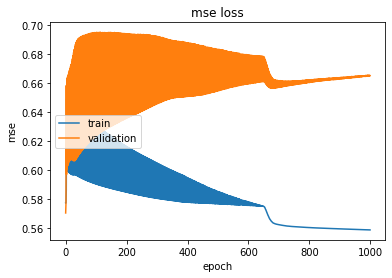

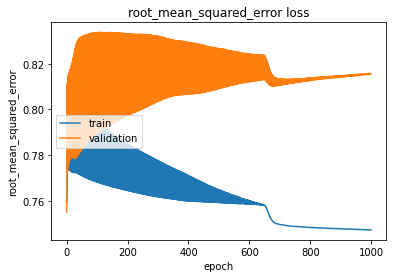

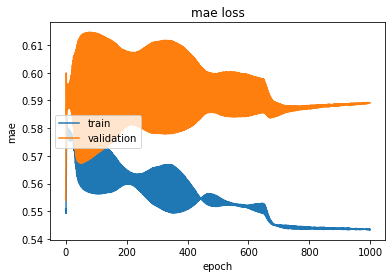

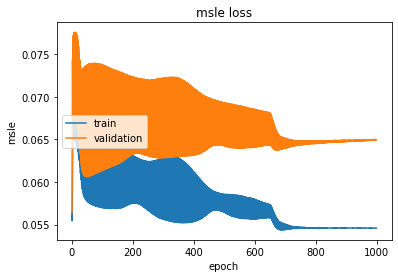

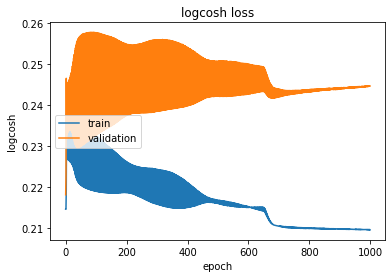

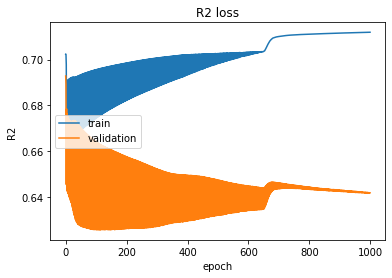

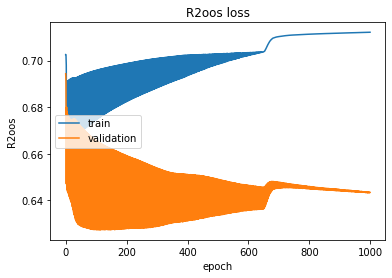

NN1 SGD 28 cech:
czas petli:  29.830992221832275
czas petli:  29.151358366012573
czas petli:  28.812279224395752
czas petli:  28.16873598098755
czas petli:  28.58737587928772
czas petli:  41.818873167037964
czas petli:  28.777286052703857
czas petli:  28.479771852493286
czas petli:  28.742184162139893
czas petli:  41.77978229522705
Czas działania pętli uczenia: 314.1665184497833
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN1df2/assets
Test loss: 0.9867862641811371
Test mse: 0.9867862641811371
Test rmse: 0.9880110740661621
Test mae: 0.6452157080173493
Test msle: 0.07090049162507057
Test logcosh: 0.2961817651987076
Test R^2: 0.466018933057785
Test R^2oos: 0.4893774837255478


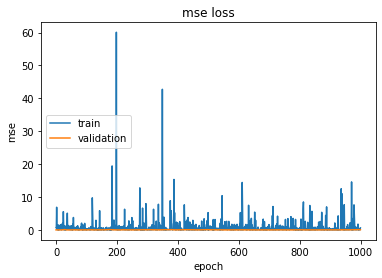

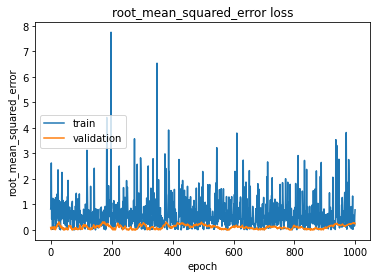

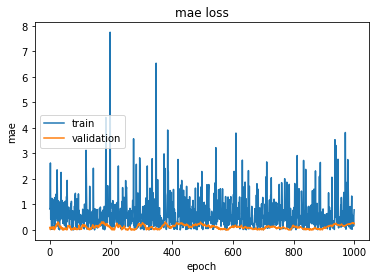

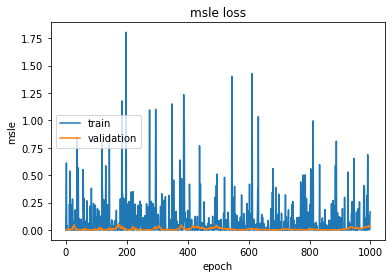

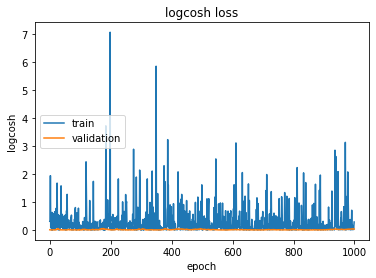

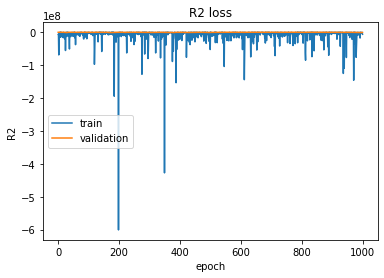

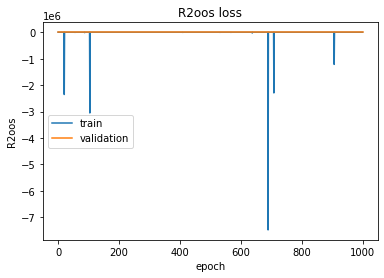

NN2 GD 28 cech:
czas petli:  30.37529754638672
czas petli:  30.798590898513794
czas petli:  30.570114135742188
czas petli:  30.042503356933594
czas petli:  29.819998502731323
czas petli:  41.587852239608765
czas petli:  31.20256495475769
czas petli:  41.59847593307495
czas petli:  31.359242916107178
czas petli:  30.499126434326172
Czas działania pętli uczenia: 327.8709418773651
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN2df2/assets
Test loss: 0.7117239594459533
Test mse: 0.7117239594459533
Test rmse: 0.8408975601196289
Test mae: 0.5913045287132264
Test msle: 0.06244202330708504
Test logcosh: 0.24524831622838975
Test R^2: 0.5714392602443695
Test R^2oos: 0.5897100269794464


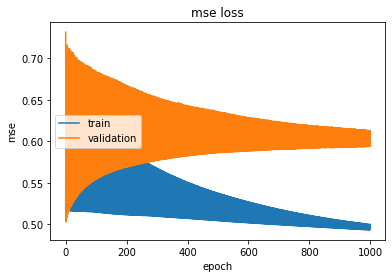

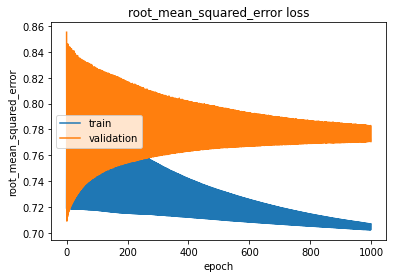

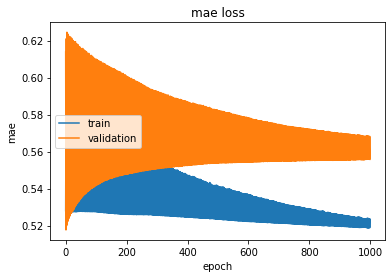

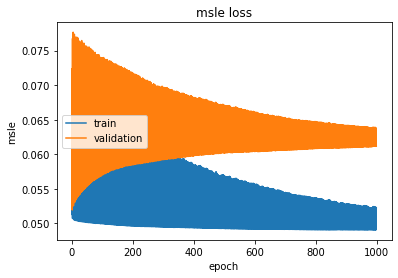

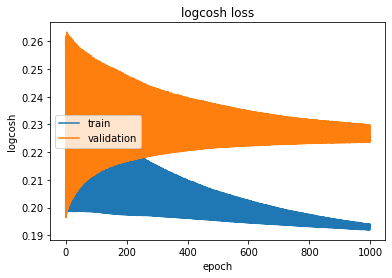

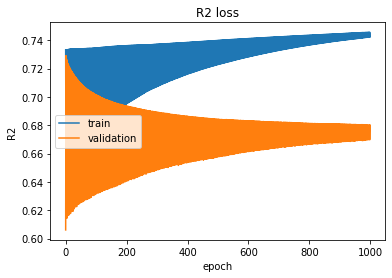

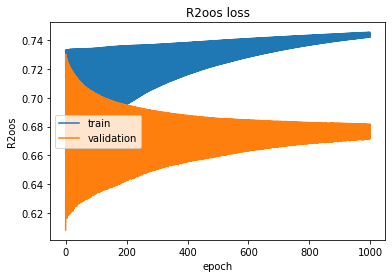

NN2 SGD 28 cech:
czas petli:  28.502320766448975
czas petli:  28.9165678024292
czas petli:  28.618171215057373
czas petli:  41.75759959220886
czas petli:  28.781014442443848
czas petli:  28.210822582244873
czas petli:  41.764403104782104
czas petli:  29.441954374313354
czas petli:  30.088592052459717
czas petli:  30.556174278259277
Czas działania pętli uczenia: 316.65498089790344
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN2df2/assets
Test loss: 0.9825372874736786
Test mse: 0.9825372874736786
Test rmse: 0.9862318217754364
Test mae: 0.6402311682701111
Test msle: 0.06963908597826958
Test logcosh: 0.29350492507219317
Test R^2: 0.4668473869562149
Test R^2oos: 0.49031985700130465


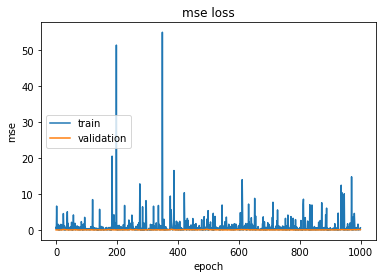

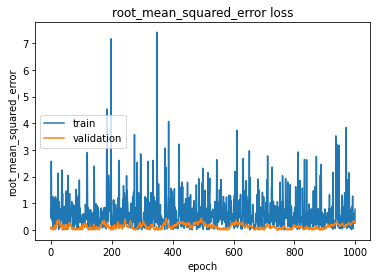

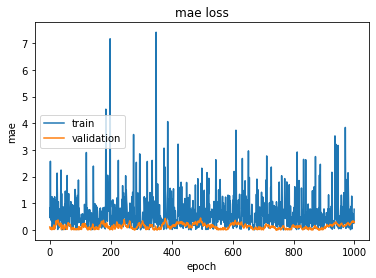

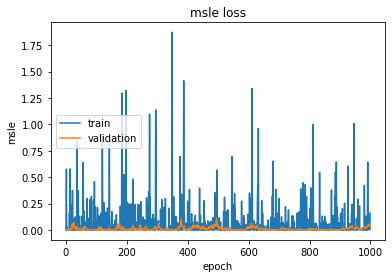

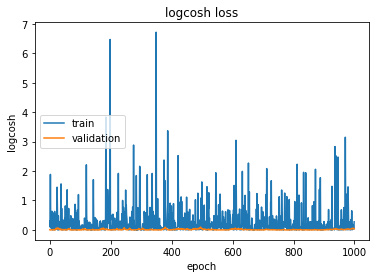

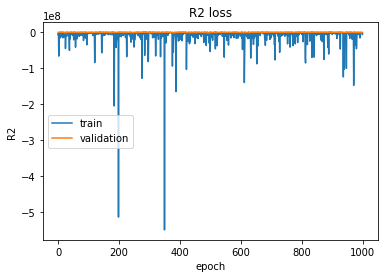

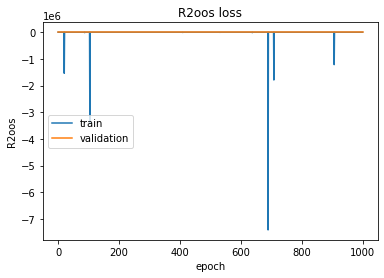

NN3 GD 28 cech:
czas petli:  32.60833740234375
czas petli:  32.92596793174744
czas petli:  31.210180044174194
czas petli:  31.024166345596313
czas petli:  30.71527647972107
czas petli:  30.530441761016846
czas petli:  30.874042510986328
czas petli:  41.623013973236084
czas petli:  30.87132716178894
czas petli:  30.28587245941162
Czas działania pętli uczenia: 322.68613839149475
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN3df2/assets
Test loss: 0.7163744986057281
Test mse: 0.7163744986057281
Test rmse: 0.8432177007198334
Test mae: 0.5904652774333954
Test msle: 0.06394856162369252
Test logcosh: 0.24503155350685119
Test R^2: 0.5726344585418701
Test R^2oos: 0.5910376906394958


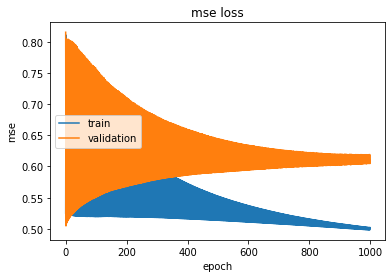

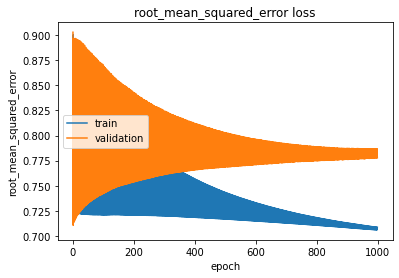

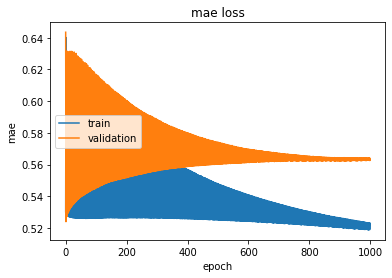

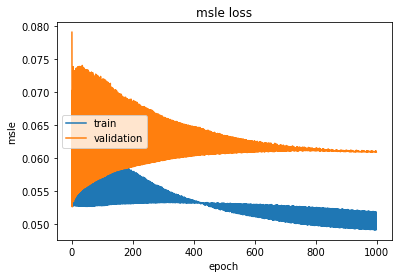

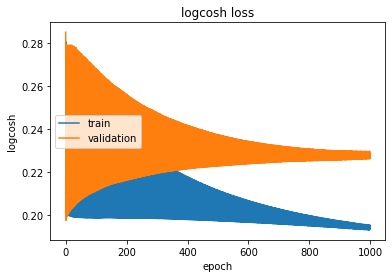

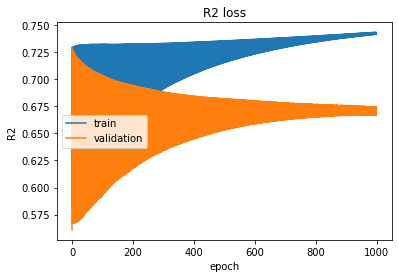

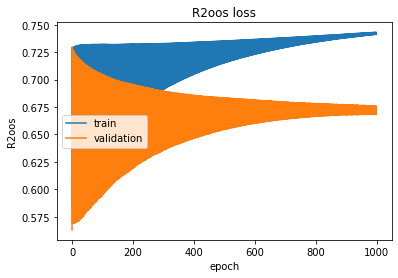

NN3 SGD 28 cechy:
czas petli:  29.260700702667236
czas petli:  41.81968641281128
czas petli:  30.055930614471436
czas petli:  29.36706781387329
czas petli:  29.119859218597412
czas petli:  28.31699848175049
czas petli:  41.793201208114624
czas petli:  41.791919231414795
czas petli:  28.42539668083191
czas petli:  28.51353669166565
Czas działania pętli uczenia: 328.48099970817566
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN3df2/assets
Test loss: 0.9994095087051391
Test mse: 0.9994095087051391
Test rmse: 0.9945149123668671
Test mae: 0.6440392851829528
Test msle: 0.07349014729261398
Test logcosh: 0.296331062912941
Test R^2: 0.45899484157562254
Test R^2oos: 0.48324749767780306


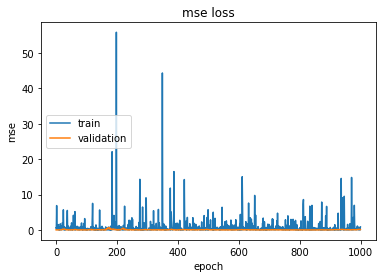

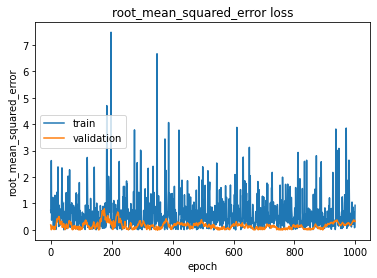

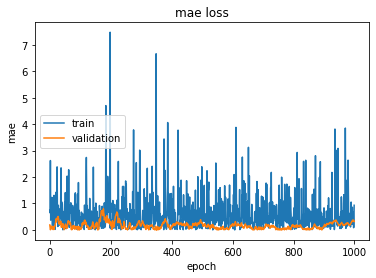

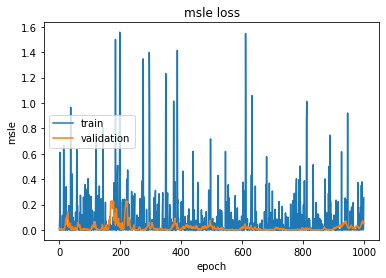

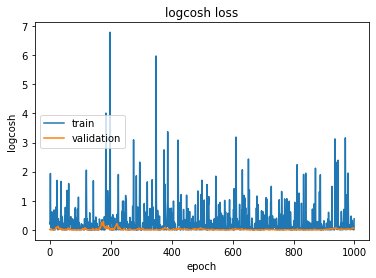

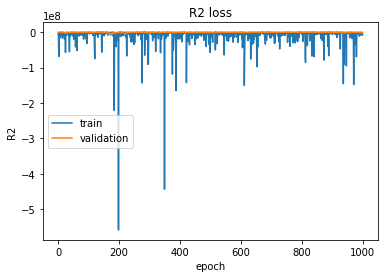

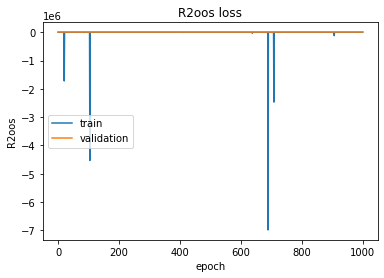

NN4 GD 28 cech:
czas petli:  31.20209789276123
czas petli:  31.980041980743408
czas petli:  31.141316652297974
czas petli:  31.039963483810425
czas petli:  30.877663612365723
czas petli:  30.637197732925415
czas petli:  30.677249670028687
czas petli:  30.451935052871704
czas petli:  30.477073669433594
czas petli:  31.688348054885864
Czas działania pętli uczenia: 310.1885633468628
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN4df2/assets
Test loss: 1.0461642563343048
Test mse: 1.0461642563343048
Test rmse: 0.9902672946453095
Test mae: 0.6859165608882904
Test msle: 0.09719653353095055
Test logcosh: 0.3173627331852913
Test R^2: 0.42566629126667976
Test R^2oos: 0.4510572185739875


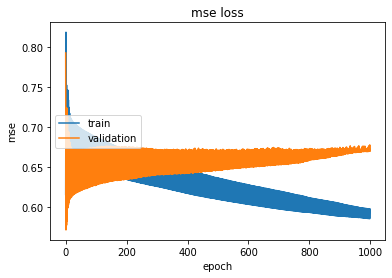

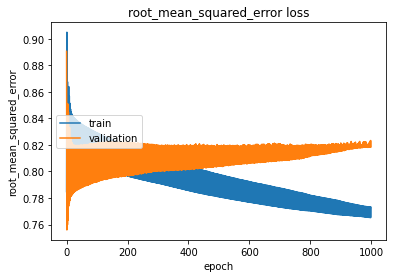

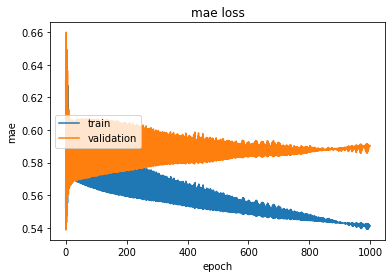

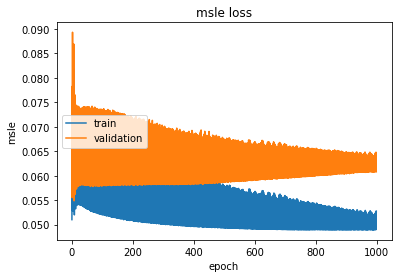

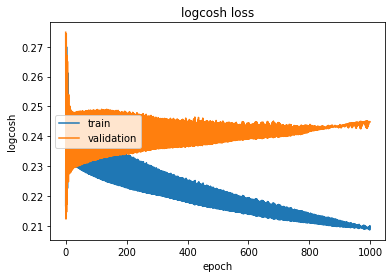

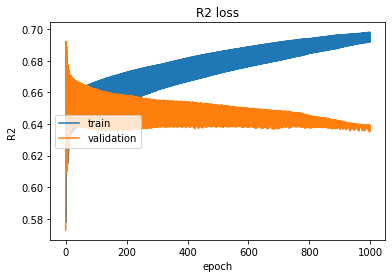

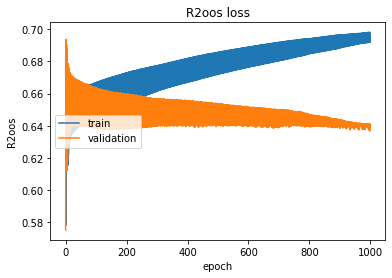

NN4 SGD 28 cech:
czas petli:  28.704081296920776
czas petli:  28.28656816482544
czas petli:  28.104936838150024
czas petli:  28.224818229675293
czas petli:  28.553815364837646
czas petli:  28.335923671722412
czas petli:  28.666919469833374
czas petli:  29.06905198097229
czas petli:  28.60939335823059
czas petli:  28.88188600540161
Czas działania pętli uczenia: 285.4564137458801
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN4df2/assets
Test loss: 1.9432589054107665
Test mse: 1.9432589054107665
Test rmse: 1.3921755790710448
Test mae: 0.9564281284809113
Test msle: 0.20644535273313522
Test logcosh: 0.533241868019104
Test R^2: -0.05214558467268944
Test R^2oos: -0.0077849446937761965


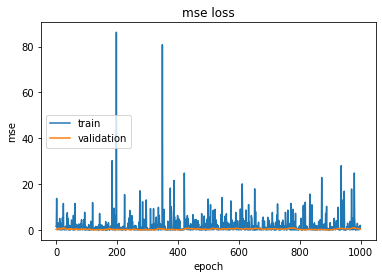

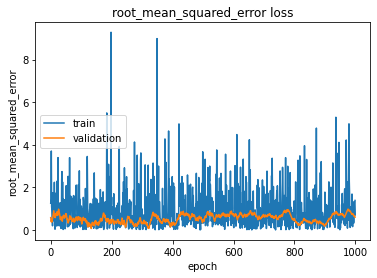

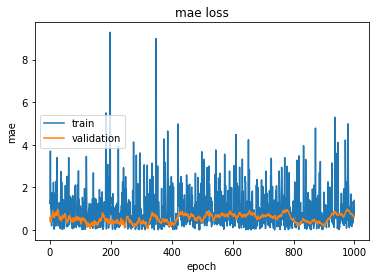

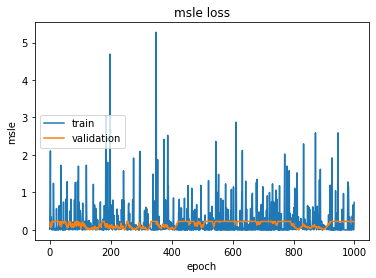

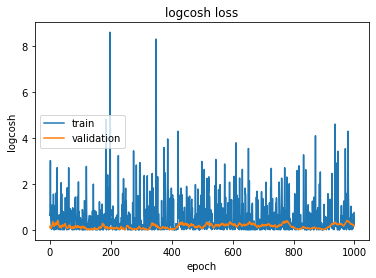

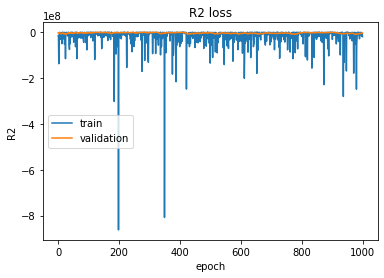

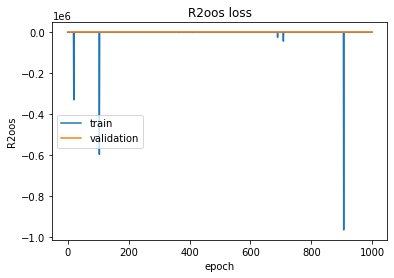

NN5 GD 28 cech:
czas petli:  33.434183835983276
czas petli:  31.759357452392578
czas petli:  31.731424570083618
czas petli:  31.576032400131226
czas petli:  31.504860401153564
czas petli:  31.84431505203247
czas petli:  31.179020881652832
czas petli:  30.911598443984985
czas petli:  31.12959361076355
czas petli:  31.004218816757202
Czas działania pętli uczenia: 316.0905795097351
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN5df2/assets
Test loss: 1.9316911578178406
Test mse: 1.9316911578178406
Test rmse: 1.388060975074768
Test mae: 0.9562298595905304
Test msle: 0.23302721232175827
Test logcosh: 0.5318703800439835
Test R^2: -0.041878356225788595
Test R^2oos: 0.00247637607390061


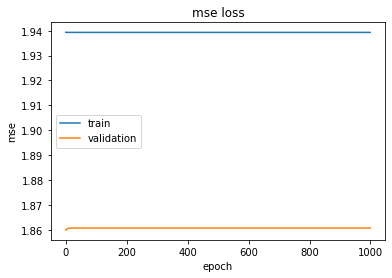

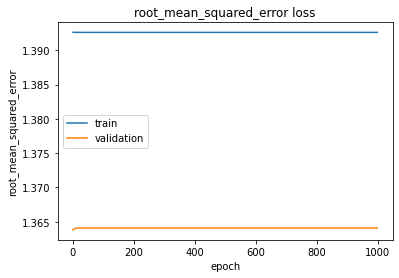

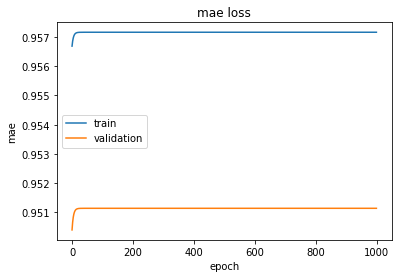

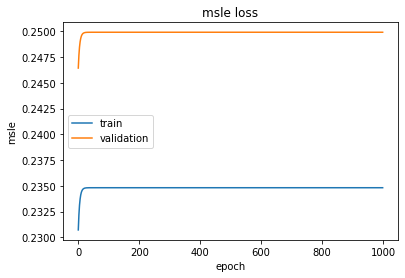

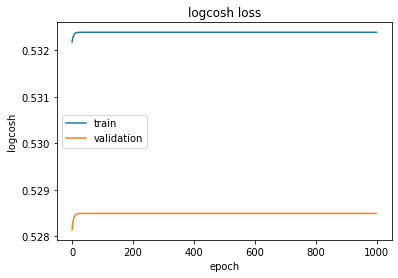

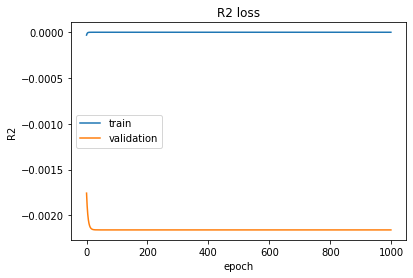

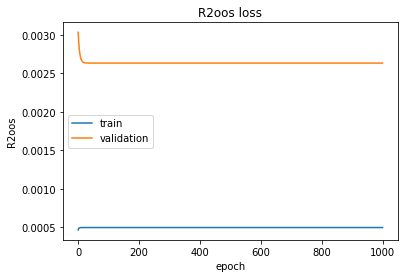

NN5 SGD 28 cech:
czas petli:  29.459823608398438
czas petli:  28.938085317611694
czas petli:  28.5011568069458
czas petli:  41.964449405670166
czas petli:  41.946799755096436
czas petli:  29.103456020355225
czas petli:  28.52383828163147
czas petli:  28.74966049194336
czas petli:  28.948484420776367
czas petli:  28.55885934829712
Czas działania pętli uczenia: 314.719030380249
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN5df2/assets
Test loss: 1.9432590842247008
Test mse: 1.9432590842247008
Test rmse: 1.3921756505966187
Test mae: 0.9564282119274139
Test msle: 0.20644573122262955
Test logcosh: 0.5332419097423553
Test R^2: -0.052145646326243876
Test R^2oos: -0.007785014508772292


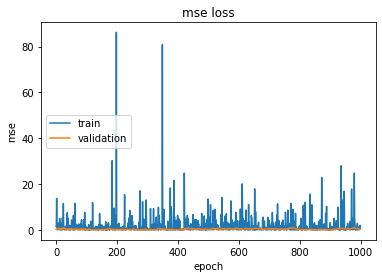

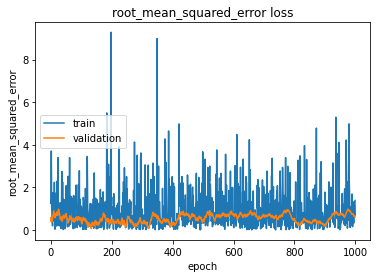

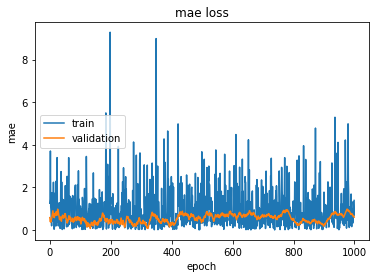

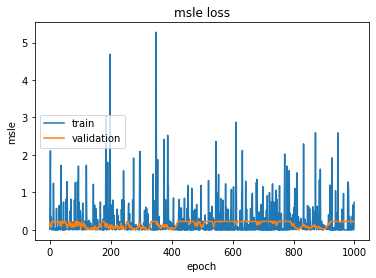

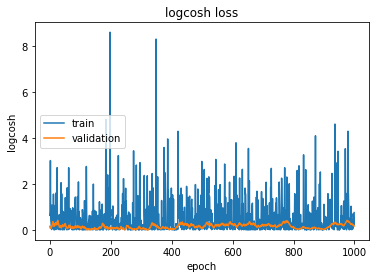

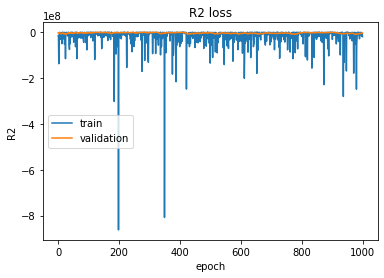

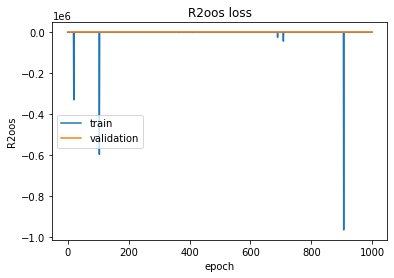

array([[ 2.09697866e+00,  2.09697866e+00,  1.44809484e+00,
         9.89875257e-01,  2.31807202e-01,  5.57643771e-01,
        -4.77168113e-02,  1.02097988e-02],
       [ 2.39945722e+00,  2.39945722e+00,  1.54901814e+00,
         1.00446391e+00,  2.03855783e-01,  5.75201631e-01,
        -4.39589135e-02,  4.94256290e-03],
       [ 2.02068758e+00,  2.02068758e+00,  1.42150891e+00,
         9.53991473e-01,  1.90291896e-01,  5.30087769e-01,
        -3.44058126e-02,  1.66310114e-03],
       [ 1.82559955e+00,  1.82559955e+00,  1.35114753e+00,
         9.41925883e-01,  2.11318031e-01,  5.19401133e-01,
        -3.58205996e-02,  2.82381731e-03],
       [ 1.63767600e+00,  1.63767600e+00,  1.27971721e+00,
         9.10081506e-01,  2.00622097e-01,  4.91117001e-01,
        -2.04890016e-02, -3.18268249e-05],
       [ 1.84920847e+00,  1.84920847e+00,  1.35985601e+00,
         9.33603108e-01,  1.71598896e-01,  5.19846559e-01,
        -6.19284771e-02, -1.84907541e-02],
       [ 1.99400747e+00,  1.994007

In [ ]:
#Trening NN na df2 (28 inputy)
print('NN1 GD 28 cech:')
cross_validation(model=GD_NN1df2, name='GD_NN1df2',data=df2, target=target, features=features2, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN1 SGD 28 cech:')
cross_validation(model=SGD_NN1df2, name='SGD_NN1df2',data=df2, target=target, features=features2, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN2 GD 28 cech:')
cross_validation(model=GD_NN2df2, name='GD_NN2df2',data=df2, target=target, features=features2, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN2 SGD 28 cech:')
cross_validation(model=SGD_NN2df2, name='SGD_NN2df2',data=df2, target=target, features=features2, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN3 GD 28 cech:')
cross_validation(model=GD_NN3df2, name='GD_NN3df2',data=df2, target=target, features=features2, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN3 SGD 28 cechy:')
cross_validation(model=SGD_NN3df2, name='SGD_NN3df2',data=df2, target=target, features=features2, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN4 GD 28 cech:')
cross_validation(model=GD_NN4df2, name='GD_NN4df2',data=df2, target=target, features=features2, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN4 SGD 28 cech:')
cross_validation(model=SGD_NN4df2, name='SGD_NN4df2',data=df2, target=target, features=features2, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN5 GD 28 cech:')
cross_validation(model=GD_NN5df2, name='GD_NN5df2',data=df2, target=target, features=features2, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN5 SGD 28 cech:')
cross_validation(model=SGD_NN5df2, name='SGD_NN5df2',data=df2, target=target, features=features2, type_of_GD='SGD', epochs=1000, n_splits=10)

NN1 GD 14 cech:
czas petli:  31.161944150924683
czas petli:  31.390942335128784
czas petli:  30.62150549888611
czas petli:  30.84980869293213
czas petli:  31.44056749343872
czas petli:  31.04478883743286
czas petli:  31.73304557800293
czas petli:  31.365994691848755
czas petli:  31.74708580970764
czas petli:  32.24719858169556
Czas działania pętli uczenia: 313.61968302726746
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN1df/assets
Test loss: 1.838848888874054
Test mse: 1.838848888874054
Test rmse: 1.3538784027099608
Test mae: 0.9472699165344238
Test msle: 0.19450290948152543
Test logcosh: 0.5198416113853455
Test R^2: -0.039920404413715006
Test R^2oos: 0.0036779655143618583


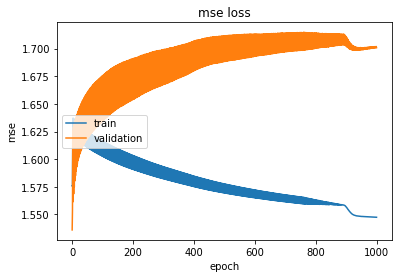

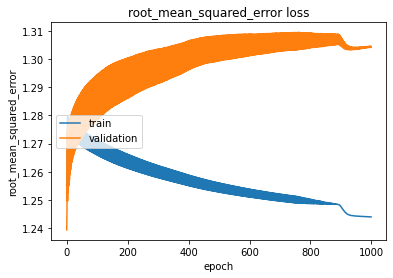

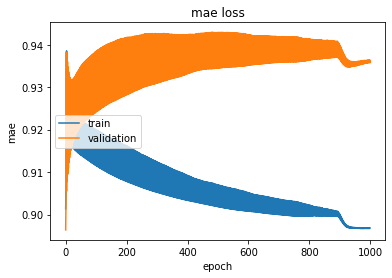

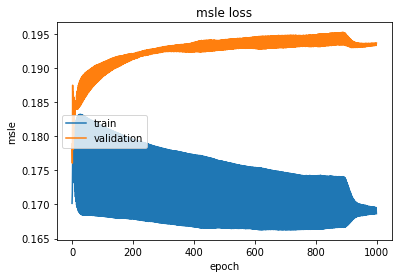

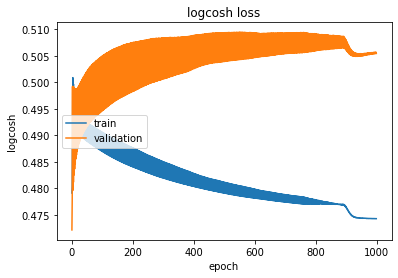

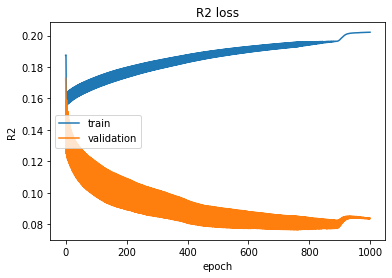

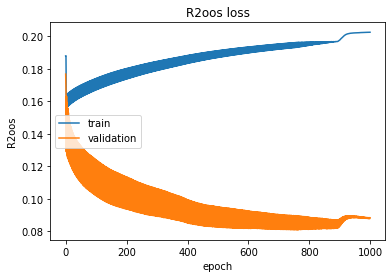

NN1 SGD 14 cech:
czas petli:  29.618571758270264
czas petli:  28.693163871765137
czas petli:  28.42119526863098
czas petli:  28.318710327148438
czas petli:  29.01301336288452
czas petli:  30.854620695114136
czas petli:  28.799445390701294
czas petli:  29.30864119529724
czas petli:  28.60285234451294
czas petli:  28.400511503219604
Czas działania pętli uczenia: 290.0483832359314
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN1df/assets
Test loss: 1.9324415802955628
Test mse: 1.9324415802955628
Test rmse: 1.388480532169342
Test mae: 0.9519585847854615
Test msle: 0.19870141744613648
Test logcosh: 0.5307382583618164
Test R^2: -0.041965725086629393
Test R^2oos: 0.001021900376508711


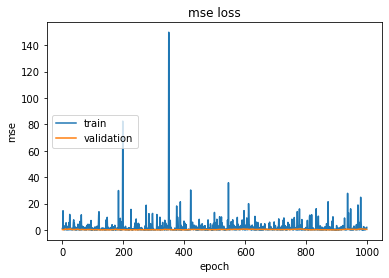

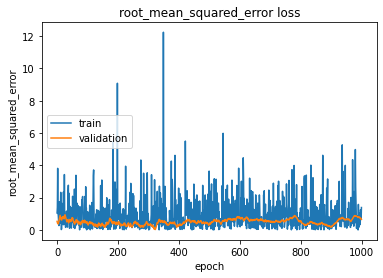

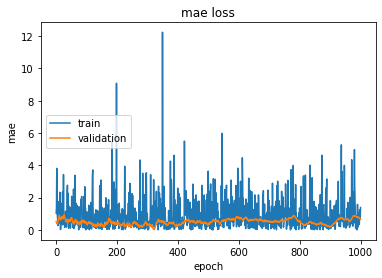

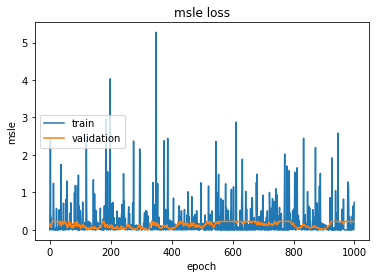

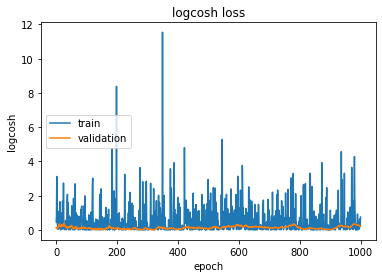

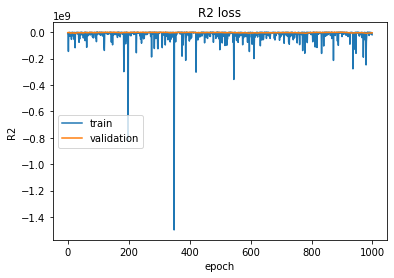

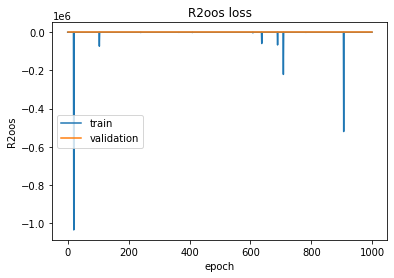

NN2 GD 14 cech:
czas petli:  30.980182886123657
czas petli:  31.316899061203003
czas petli:  41.586281538009644
czas petli:  30.695595264434814
czas petli:  29.849219799041748
czas petli:  30.364492416381836
czas petli:  30.003013134002686
czas petli:  29.836846828460693
czas petli:  29.778543949127197
czas petli:  41.655532121658325
Czas działania pętli uczenia: 326.0839190483093
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN2df/assets
Test loss: 1.7842633843421936
Test mse: 1.7842633843421936
Test rmse: 1.3316961646080017
Test mae: 0.9317084372043609
Test msle: 0.18459182232618332
Test logcosh: 0.5091748893260956
Test R^2: -0.02161269704811275
Test R^2oos: 0.019652160163968802


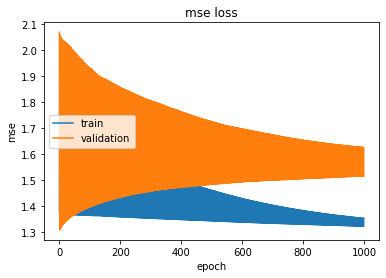

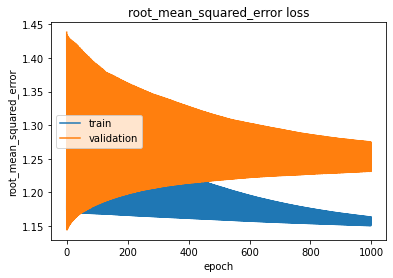

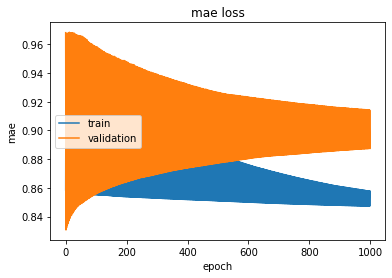

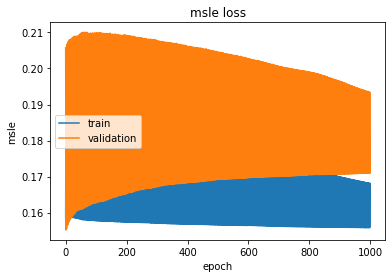

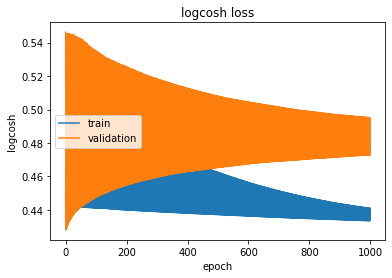

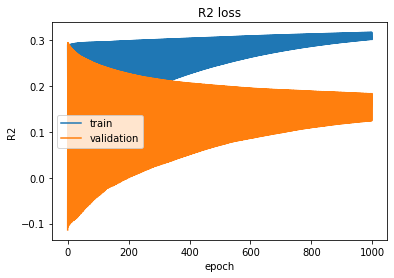

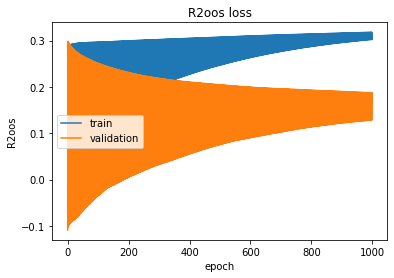

NN2 SGD 14 cech:
czas petli:  30.173210382461548
czas petli:  28.906156539916992
czas petli:  41.81561517715454
czas petli:  28.015807390213013
czas petli:  28.56233859062195
czas petli:  28.906493663787842
czas petli:  29.22324275970459
czas petli:  29.00035285949707
czas petli:  41.792051792144775
czas petli:  30.641611337661743
Czas działania pętli uczenia: 317.05415987968445
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN2df/assets
Test loss: 1.9314961433410645
Test mse: 1.9314961433410645
Test rmse: 1.3879674196243286
Test mae: 0.9512891411781311
Test msle: 0.19953278750181197
Test logcosh: 0.5299508720636368
Test R^2: -0.03695945618674159
Test R^2oos: 0.006096726143732667


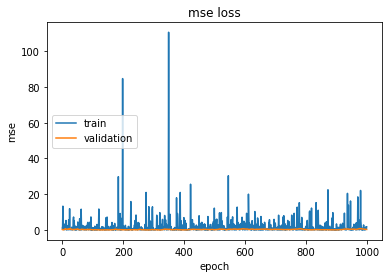

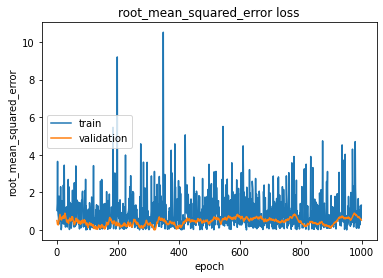

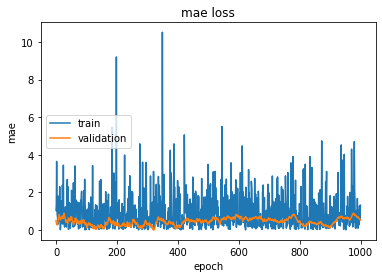

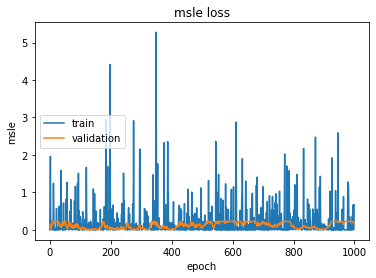

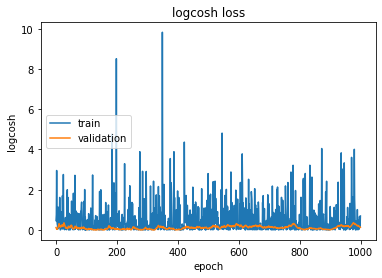

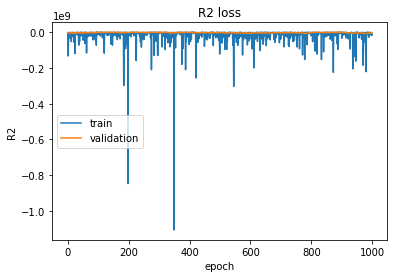

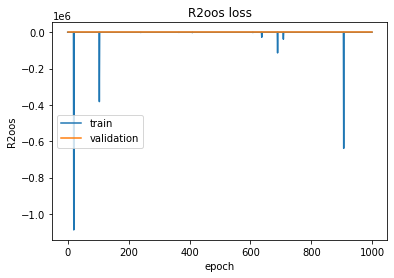

NN3 GD 14 cech:
czas petli:  41.73729228973389
czas petli:  41.65008807182312
czas petli:  33.37170672416687
czas petli:  33.49596858024597
czas petli:  32.83693313598633
czas petli:  32.747339725494385
czas petli:  33.01993727684021
czas petli:  33.43026685714722
czas petli:  33.21317219734192
czas petli:  32.91319823265076
Czas działania pętli uczenia: 348.4342727661133
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN3df/assets
Test loss: 1.793418323993683
Test mse: 1.793418323993683
Test rmse: 1.3364253759384155
Test mae: 0.9361596822738647
Test msle: 0.19878599792718887
Test logcosh: 0.5128091961145401
Test R^2: -0.003753906162455678
Test R^2oos: 0.03661740642273799


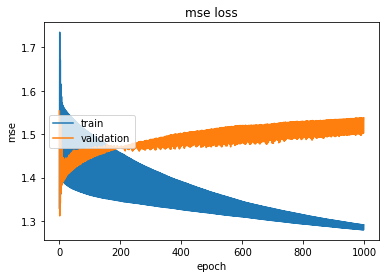

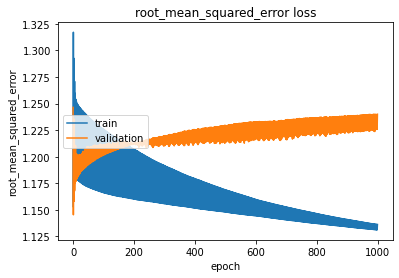

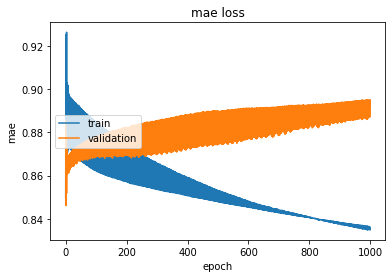

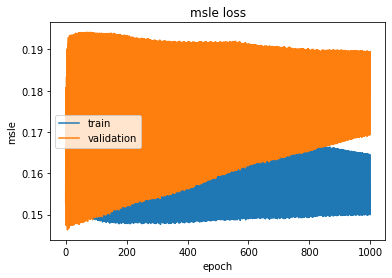

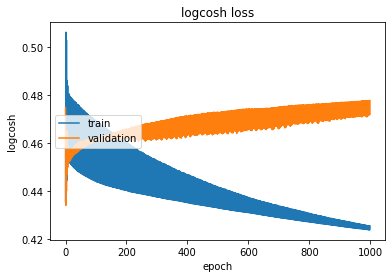

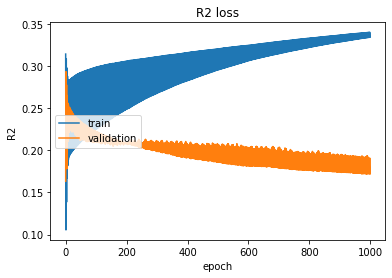

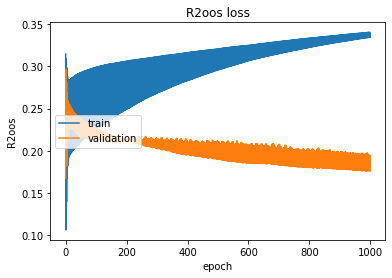

NN3 SGD 14 cech:
czas petli:  41.854039907455444
czas petli:  30.351636171340942
czas petli:  30.221601009368896
czas petli:  41.92717623710632
czas petli:  30.951988220214844
czas petli:  30.29757261276245
czas petli:  30.002573490142822
czas petli:  33.18076705932617
czas petli:  41.91813039779663
czas petli:  31.093172311782837
Czas działania pętli uczenia: 341.81760239601135
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN3df/assets
Test loss: 1.9432576894760132
Test mse: 1.9432576894760132
Test rmse: 1.3921751260757447
Test mae: 0.9564272701740265
Test msle: 0.20643846392631532
Test logcosh: 0.5332414448261261
Test R^2: -0.052147183939814566
Test R^2oos: -0.007786203280193149


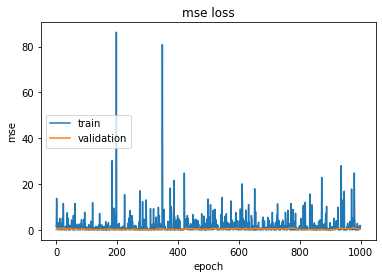

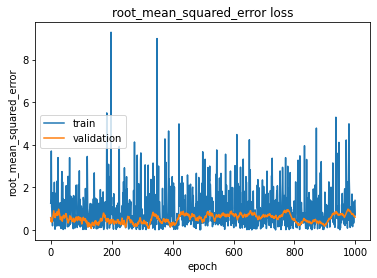

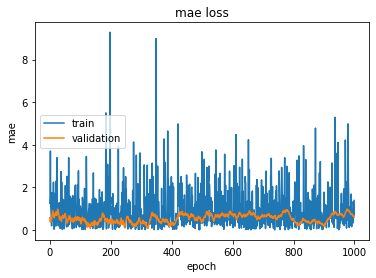

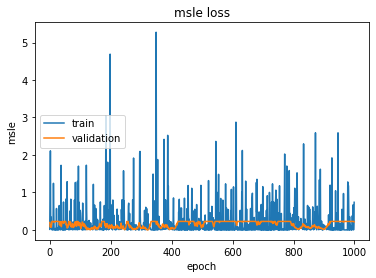

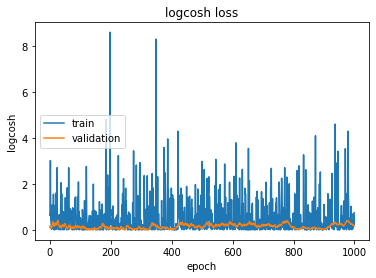

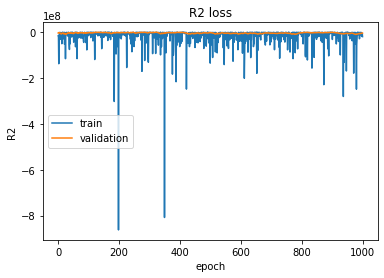

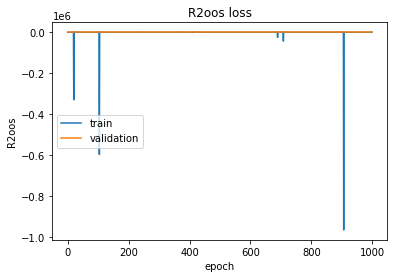

NN4 GD 14 cech:
czas petli:  41.69105076789856
czas petli:  34.39292049407959
czas petli:  34.0010347366333
czas petli:  33.7014377117157
czas petli:  33.42518210411072
czas petli:  33.105228662490845
czas petli:  41.74644613265991
czas petli:  41.65046143531799
czas petli:  33.68567991256714
czas petli:  33.20812392234802
Czas działania pętli uczenia: 360.6260278224945
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN4df/assets
Test loss: 1.9316890478134154
Test mse: 1.9316890478134154
Test rmse: 1.3880602240562439
Test mae: 0.9562291085720063
Test msle: 0.2330269306898117
Test logcosh: 0.531869825720787
Test R^2: -0.04187617301940918
Test R^2oos: 0.0024784316250588746


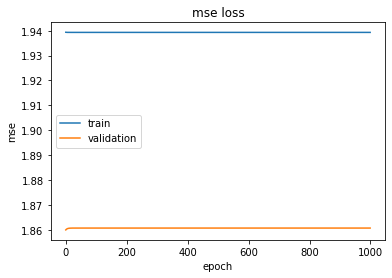

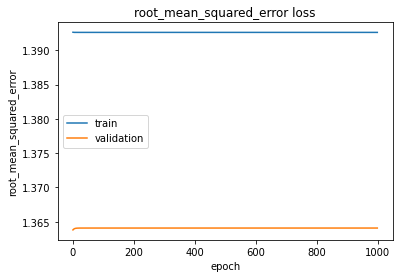

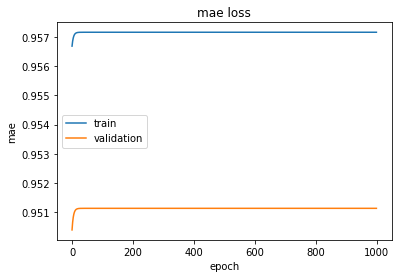

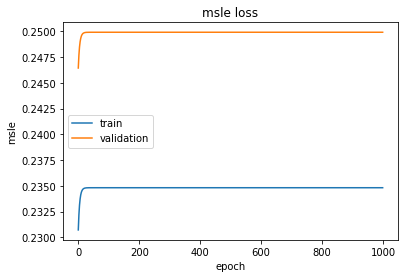

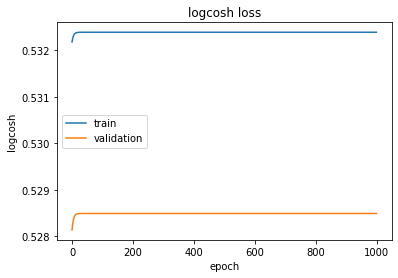

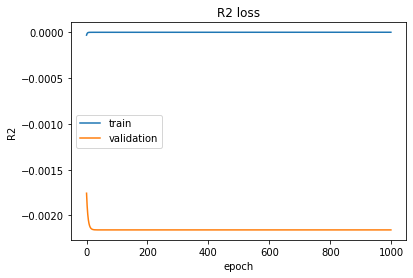

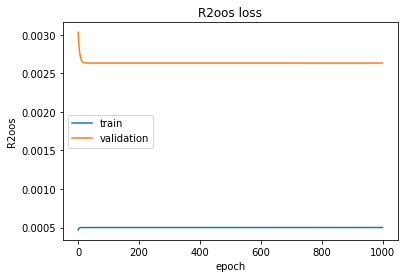

NN4 SGD 14 cech:
czas petli:  41.908772706985474
czas petli:  30.651456117630005
czas petli:  30.495810985565186
czas petli:  30.502290964126587
czas petli:  30.381114721298218
czas petli:  31.57804298400879
czas petli:  30.34190535545349
czas petli:  30.30759024620056
czas petli:  30.302353143692017
czas petli:  30.3961021900177
Czas działania pętli uczenia: 316.88392162323
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN4df/assets
Test loss: 1.9432578086853027
Test mse: 1.9432578086853027
Test rmse: 1.3921751856803894
Test mae: 0.9564280211925507
Test msle: 0.206447334587574
Test logcosh: 0.5332416832447052
Test R^2: -0.05214463695883751
Test R^2oos: -0.007783981509419391


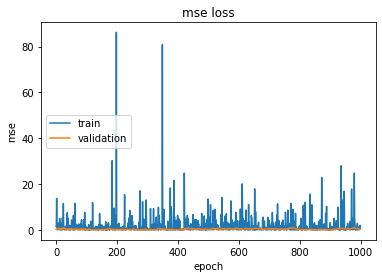

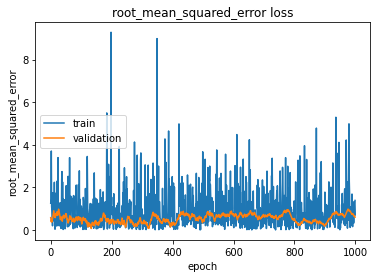

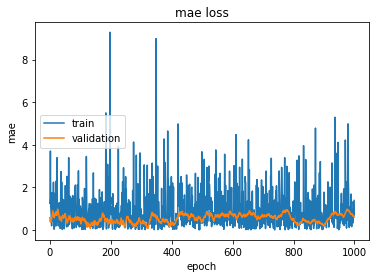

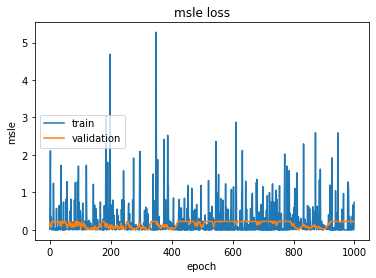

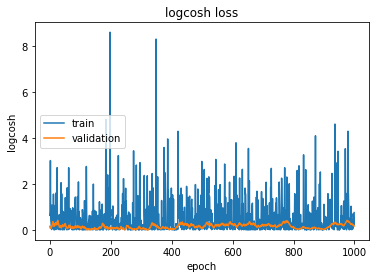

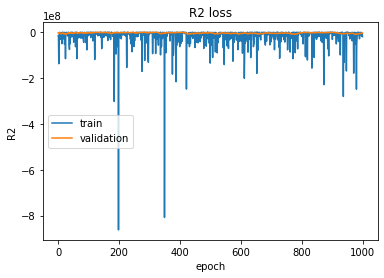

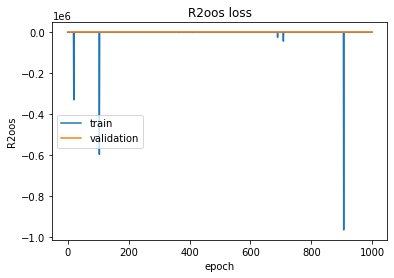

NN5 GD 14 cech:
czas petli:  34.65475416183472
czas petli:  34.45293664932251
czas petli:  34.58413124084473
czas petli:  34.645519733428955
czas petli:  34.41095042228699
czas petli:  33.97676181793213
czas petli:  33.6071240901947
czas petli:  33.47764754295349
czas petli:  33.84736943244934
czas petli:  33.73279905319214
Czas działania pętli uczenia: 341.40740609169006
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/GD_NN5df/assets
Test loss: 1.9316911697387695
Test mse: 1.9316911697387695
Test rmse: 1.388060975074768
Test mae: 0.9562298715114593
Test msle: 0.2330272063612938
Test logcosh: 0.5318703770637512
Test R^2: -0.04187842160463333
Test R^2oos: 0.0024763152468949556


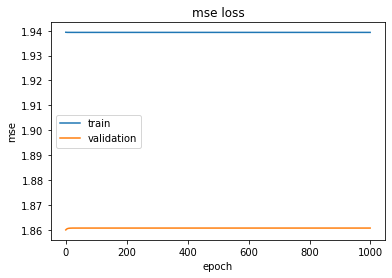

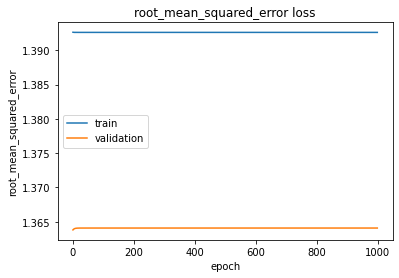

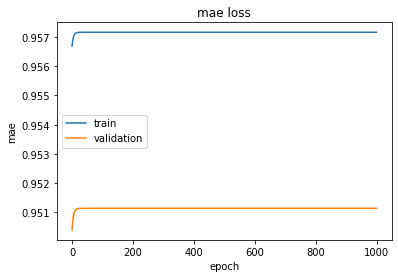

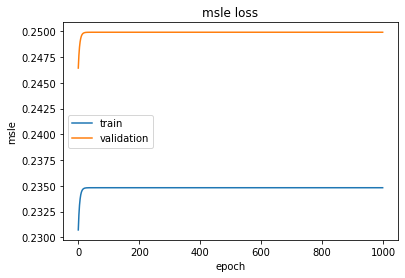

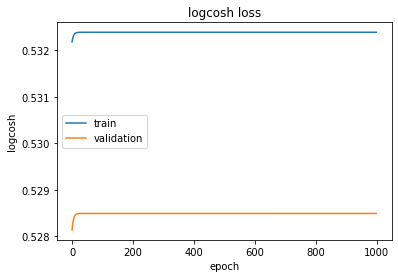

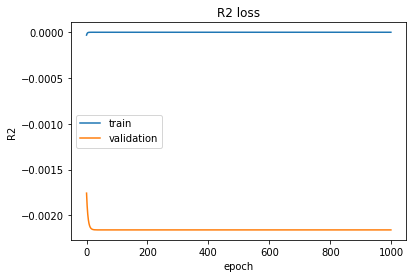

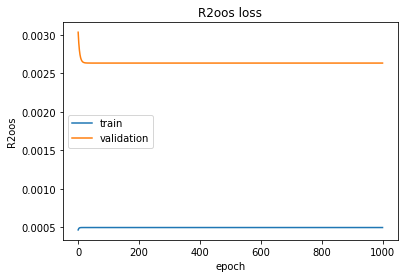

NN5 SGD 14 cech:
czas petli:  31.180290699005127
czas petli:  31.63529133796692
czas petli:  30.592907428741455
czas petli:  41.91415333747864
czas petli:  30.575815200805664
czas petli:  30.508580446243286
czas petli:  30.43231201171875
czas petli:  30.20819354057312
czas petli:  31.757709741592407
czas petli:  41.93211579322815
Czas działania pętli uczenia: 330.75528264045715
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks2/SGD_NN5df/assets
Test loss: 1.94325909614563
Test mse: 1.94325909614563
Test rmse: 1.3921756505966187
Test mae: 0.9564281821250915
Test msle: 0.20644546747207643
Test logcosh: 0.5332418978214264
Test R^2: -0.05214566756039858
Test R^2oos: -0.007785026395504246


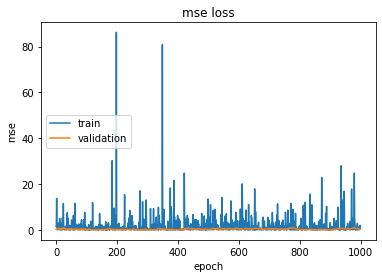

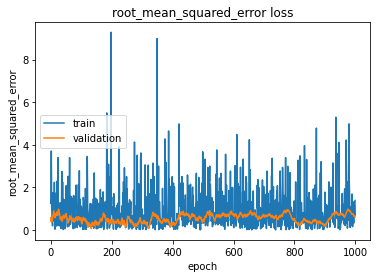

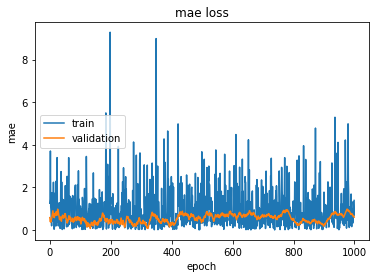

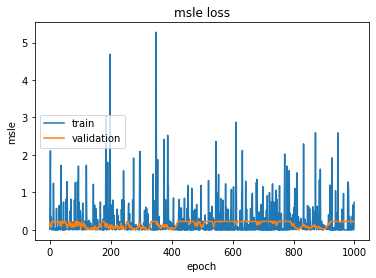

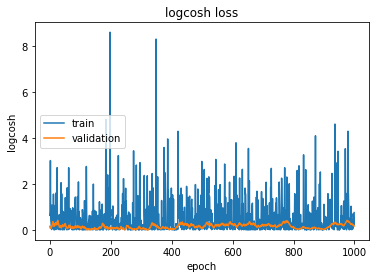

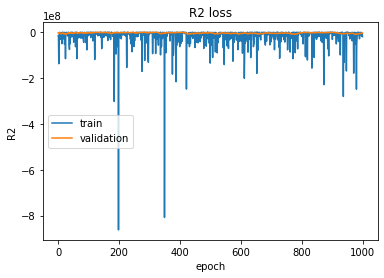

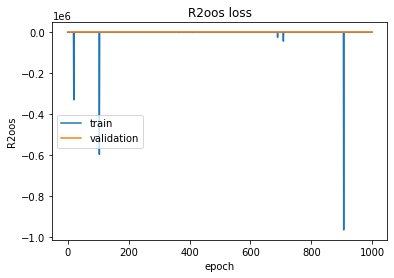

array([[ 2.09697866e+00,  2.09697866e+00,  1.44809484e+00,
         9.89875257e-01,  2.31807202e-01,  5.57643771e-01,
        -4.77168113e-02,  1.02097988e-02],
       [ 2.39945745e+00,  2.39945745e+00,  1.54901826e+00,
         1.00446391e+00,  2.03855783e-01,  5.75201631e-01,
        -4.39589173e-02,  4.94255917e-03],
       [ 2.02068758e+00,  2.02068758e+00,  1.42150891e+00,
         9.53991473e-01,  1.90291926e-01,  5.30087769e-01,
        -3.44058201e-02,  1.66309287e-03],
       [ 1.82559955e+00,  1.82559955e+00,  1.35114753e+00,
         9.41925883e-01,  2.11318031e-01,  5.19401133e-01,
        -3.58205996e-02,  2.82381731e-03],
       [ 1.63767612e+00,  1.63767612e+00,  1.27971721e+00,
         9.10081565e-01,  2.00622141e-01,  4.91117001e-01,
        -2.04890389e-02, -3.18597085e-05],
       [ 1.84920847e+00,  1.84920847e+00,  1.35985601e+00,
         9.33603108e-01,  1.71598896e-01,  5.19846559e-01,
        -6.19284771e-02, -1.84907541e-02],
       [ 1.99400747e+00,  1.994007

In [ ]:
#Trening NN na df (14 inputów)
print('NN1 GD 14 cech:')
cross_validation(model=GD_NN1df, name='GD_NN1df',data=df, target=target, features=features, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN1 SGD 14 cech:')
cross_validation(model=SGD_NN1df, name='SGD_NN1df',data=df, target=target, features=features, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN2 GD 14 cech:')
cross_validation(model=GD_NN2df, name='GD_NN2df',data=df, target=target, features=features, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN2 SGD 14 cech:')
cross_validation(model=SGD_NN2df, name='SGD_NN2df',data=df, target=target, features=features, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN3 GD 14 cech:')
cross_validation(model=GD_NN3df, name='GD_NN3df',data=df, target=target, features=features, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN3 SGD 14 cech:')
cross_validation(model=SGD_NN3df, name='SGD_NN3df',data=df, target=target, features=features, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN4 GD 14 cech:')
cross_validation(model=GD_NN4df, name='GD_NN4df',data=df, target=target, features=features, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN4 SGD 14 cech:')
cross_validation(model=SGD_NN4df, name='SGD_NN4df',data=df, target=target, features=features, type_of_GD='SGD', epochs=1000, n_splits=10)
print('NN5 GD 14 cech:')
cross_validation(model=GD_NN5df, name='GD_NN5df',data=df, target=target, features=features, type_of_GD='GD', epochs=1000, n_splits=10)
print('NN5 SGD 14 cech:')
cross_validation(model=SGD_NN5df, name='SGD_NN5df',data=df, target=target, features=features, type_of_GD='SGD', epochs=1000, n_splits=10)